# **EDA + DATACLEANING + PREPROCESSING**
---

**Objetivo**

El objetivo de este trabajo es poder predecir el precio de un vehículo de la marca BMW, partiendo de un dataset que contiene registros de diferentes modelos de la marca, con las características de cada uno de ellos.

Para ello, se ha hecho un tratamiento de los datos en 4 fases:
1. EDA ( Exploratory Data Analysis )
2. Data Cleaning
3. Pre-processing

**Importación de librerías**

In [1]:
# Sistema operativo
import os

# silence warnings
import warnings
warnings.filterwarnings("ignore")

# Pandas y Numpy
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib import pyplot as plt
%matplotlib inline

# Versiones de las librerías instaladas
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")

# transformers
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Config
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format

Working with these versions of libraries

Numpy version 1.21.5
Pandas version 1.4.4


**Creación de carpetas**

In [594]:
dir = ['data', 'report', 'final']
for i in dir:
   os.mkdir(i)
del dir

**Ruta del dataset**

Descargamos el dataset desde el siguiente link y lo metemos dentro de la carpeta 'data':

https://drive.google.com/file/d/1gW6QzKEW9HZ6uYi4kAwv2n_J7lwKP85k/view?usp=drive_link

In [595]:
# Si se usa Collab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
CWD = os.getcwd() # Ruta actual
DATA_PATH = os.path.join(CWD, "data") # Ruta de la carpeta Data

print(CWD)
print(DATA_PATH)

d:\Data_Science\EDA_CLEANING_PREPROCCESING\Eda-DataCleaning-Preprocessing-BMWPricing
d:\Data_Science\EDA_CLEANING_PREPROCCESING\Eda-DataCleaning-Preprocessing-BMWPricing\data


**Clases y funciones**

**DataFrameReporter**
Nos va a permitir hacer un primer contacto con el dataset.\
Se trata de una clase auxiliar que hará una parte del **EDA**.

In [3]:
class DataFrameReporter(object):
    '''
    Helper class that reports nulls and datatypes of columns
    '''
    def __init__(self, df): # Variables que le tengo que suministrar a la clase
        '''
        Constructor for the class.
        Needs dataframe
        '''
        self.df = df
               
    def analyze_X(self, X):
        '''
        Analyses the DataFrame you pass and returns a report of nulls, distribution and other goodies.
        '''        
               
        dtypes = X.dtypes.to_frame().rename(columns = {0:"Dtypes"}) # Tipos de variables

        nulls_in_X = X.isnull().sum().to_frame().rename(columns = {0:"Absolute_nulls"}) # Número de nulos en las variables
        nulls_in_X["Relative_nulls"] = nulls_in_X["Absolute_nulls"]/X.shape[0]
        nulls_in_X["Relative_nulls"] = nulls_in_X["Relative_nulls"].apply(
            lambda number: round(number, 3) * 100 # Relative_nulls = (Absolute_nulls/Shape)*100 ... con 3 cifras significativas
        )
        
        nulls_in_X = pd.concat([nulls_in_X, dtypes], axis = 1)
        nulls_in_X["Shape"] = X.shape[0] # Número de registros
        nulls_in_X = nulls_in_X[["Dtypes", "Shape", "Absolute_nulls", "Relative_nulls"]] # Ordeno las columnas

         
        describe_values_num = X.describe().T # Describe de las variables numéricas
        report_df = pd.concat([nulls_in_X, describe_values_num], axis = 1)
               
        describe_values_cat = X.describe(exclude = "number").T # Describe de las variables categóricas
        report_df = pd.concat([report_df, describe_values_cat], axis = 1)

        report_df.fillna("", inplace = True) # Imputo los nulos con un vacío
        report_df.sort_values("Dtypes", ascending = True, inplace = True) # Ordeno las variables por tipos
        
        return report_df
        
    def get_reports(self):
        '''
        Calls analyze_X method and returns report DataFrame for train and test.
        '''
        report_df = self.analyze_X(X = self.df)
                
        return report_df

In [4]:
# Elimina duplicados
def drop_duplicates (dataframe):
    '''
    Elimina filas duplicadas del dataset
    '''
    print(f"{dataframe.shape}")
    df_duplicated = dataframe[dataframe.duplicated(keep = False)]
    print(f"Se han eliminado {len(dataframe[dataframe.duplicated()])} registros repetidos")
    dataframe.drop_duplicates(inplace = True)
    print(f"{dataframe.shape}")

    return df_duplicated

In [5]:
# Nulos en variables
def nulos_variable (dataframe):
    ''' 
    Muestra los nulos que hay
    '''
    nulos_numericas = dataframe.select_dtypes(include = np.number).isnull().sum()[dataframe.select_dtypes(include = np.number).isnull().sum() > 0]
    nulos_categoricas =dataframe.select_dtypes(exclude = np.number).isnull().sum()[dataframe.select_dtypes(exclude = np.number).isnull().sum() > 0]

    print ('Las variables numéricas que tienen nulos son:\n', nulos_numericas, '\n\nHay un total de', len(nulos_numericas), 'variables numéricas con nulos')
    print ('\n\nLas variables categóricas que tienen nulos son:\n', nulos_categoricas, '\n\nHay un total de', len(nulos_categoricas), 'variables categóricas con nulos')
    print ('\n\nVARIABLES TOTALES CON NULOS:', len(nulos_numericas)+len(nulos_categoricas))

In [6]:
# Eliminación de variables con baja varianza
def varianza_nula (dataframe):
    ''' 
    Elimina variables con baja varianza    
    '''

    df_microsoft_numerical_describe = dataframe.describe(include=np.number).T
    lista_numerica_baja_varianza = df_microsoft_numerical_describe[(df_microsoft_numerical_describe['std']<0.15)].index.tolist() # Indico la varianza
    dataframe.drop(lista_numerica_baja_varianza, axis=1, inplace=True)
    print('Se han borrado las siguientes variables numéricas por tener baja varianza:\n',lista_numerica_baja_varianza )

    return dataframe

In [7]:
# Separación de variables
target = ['precio'] # indico quién es la variable a predecir

def obtener_lista_variables(dataframe):
  ''' 
  Obtengo listas de variables
  '''

  lista_numerica=[]
  lista_boolean=[] # numerica y con 2 valores
  lista_categorica=[] # object sin datatime

  for i in dataframe: # si no especifico, aplica a las columnas (es como poner for i in dataset.columns:)
    if (dataframe[i].dtype.kind == 'i'or dataframe[i].dtype.kind == 'f' or dataframe[i].dtype.kind == 'b') and len(dataframe[i].unique())!=2\
     and i not in target:
      lista_numerica.append(i)
    elif (dataframe[i].dtype.kind == 'i'or dataframe[i].dtype.kind == 'f' or dataframe[i].dtype.kind == 'b') and len(dataframe[i].unique()) ==2\
     and i not in target:
      lista_boolean.append(i)
    elif (dataframe[i].dtype.kind == 'O') and i not in target: # pongo elif y no else para que no me entre el datetime como categorica
      lista_categorica.append(i)


  return lista_numerica, lista_boolean, lista_categorica

In [8]:
# Visualización del target
def plot_target(dataframe, target):
    ''' 
    Visualización del target
    '''
    
    plt.figure(figsize=(20,6))
    plt.title(f'Analisis del {target}')  

    ax1 = plt.subplot (1,2,1)
    ax1 = sns.boxplot(x = dataframe[target])
    ax2 = plt.subplot (1,2,2)
    ax2 = plt.hist(x = dataframe[target])

In [9]:
# Análisis de las variables numéricas VS target
def analisis_numericas (dataframe, column, target):
    '''
    Pivot-table que me da las medidas de las variables numericas y su correlación con el target
    '''
    
    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len, min, np.mean, max]).sort_values(by=(column),ascending=True)

In [10]:
# Visualización de las variables numéricas VS target
def plot_numericas(dataframe,column,target):
    '''
    Visualización de las variables numéricas y su correlación con el target
    '''  
      
    plt.figure(figsize=[20,6])
    plt.title(f'Analisis de {column} VS {target}')
    if column=='HIJOS':
        sns.boxplot(x = column, y = target, data = dataframe, palette="coolwarm")
    
    else:
        sns.scatterplot(x = column, y = target, data = dataframe )
  
    return plt.show()

In [11]:
# Análisis de las variables categóricas VS target
def analisis_categoricas (dataframe,column,target):
    '''
    Pivot-table que me da las medidas de las variables categóricas y su correlación con el target
    '''

    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len, min, np.mean, max]).sort_values(by=('len', target),ascending=False)

In [12]:
# Visualización de las variables categóricas VS target
def plot_categoricas(dataframe,column,target):
    '''
    Visualización de las variables categóricas y su correlación con el target
    '''    
    
    plt.figure(figsize=[20,6])
    plt.title(f'Analisis de {column} VS {target}')
    
    ax1 = plt.subplot (1,2,1)
    ax1 = sns.boxplot(x=column, y=target, data= dataframe, palette="coolwarm")
    ax2 = plt.subplot (1,2,2)
    ax2 = sns.violinplot(x=column, y=target, data= dataframe, palette="coolwarm")  

    return plt.show()

In [13]:
# Análisis de las variables booleanas VS target
def analisis_booleanas (dataframe,column,target):
    '''
    Pivot-table que me da las medidas de las variables booleanas y su correlación con el target
    '''
    
    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len, min, np.mean, max]).sort_values(by=('len', target),ascending=False)

In [14]:
# Visualización de las variables booleanas VS target
def plot_booleanas(dataframe,column,target):
    '''
    Visualización de las variables booleanas y su correlación con el target
    '''    
    
    plt.figure(figsize=[20,6])
    plt.title(f'Analisis de {column} VS {target}')
    
    ax1 = plt.subplot (1,2,1)
    ax1 = sns.boxplot(x=column, y=target, data= dataframe, palette="coolwarm")
    ax2 = plt.subplot (1,2,2)
    ax2 = sns.violinplot(x=column, y=target, data= dataframe, palette="coolwarm")  

    return plt.show()

In [15]:
# column --> columna sobre la que actuamos
# num_values --> número de eqiquetas que queremos limitar
# No meter el inplace en el fillna hasta comprobar que funciona bien
def setOthers(dataframe, column, num_values): 
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others', inplace = True) 

In [16]:
def corr_alta (dataframe, correlacion):
    ''' 
    Variables con alta correlación
    '''
    corr = dataframe.corr()
    corr2 = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)) # Me quedo con los valores triangulares superiores ya que es una matriz simétrica
    corr2 = corr2.stack(level = -1 , dropna = True) # Apila los datos en una columna. El último nivel es el "-1" y no se muestran los nulos
    corr_variables = corr2.sort_values()[(corr2.sort_values()>=correlacion) | (corr2.sort_values()<=-correlacion)] # Indico el grado de correlación

    return corr_variables

## **1.- Data Loading**

In [17]:
bmw = pd.read_csv(os.path.join(DATA_PATH, "bmw_pricing.csv"), sep = ",")
bmw.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,BMW,118,"140,411.00",100.00,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,"11,300.00",2018-01-01
1,BMW,M4,"13,929.00",317.00,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,"69,700.00",2018-02-01
2,BMW,320,"183,297.00",120.00,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,"10,200.00",2018-02-01
3,BMW,420,"128,035.00",135.00,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,"25,100.00",2018-02-01
4,BMW,425,"97,097.00",160.00,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,"33,400.00",2018-04-01


**Eliminar filas repetidas**

In [18]:
drop_duplicates (dataframe = bmw)

(4843, 18)
Se han eliminado 0 registros repetidos
(4843, 18)


,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta


No hay registros repetidos

## **2.- EDA** --> *DATA UNDERTANDING*

### 2.1.- ANÁLISIS UNIVARIANTE DE LOS DATOS

**A.- Data Size**

In [19]:
#Tamaño del dataset
bmw.size

87174

In [20]:
# Filas y columnas
bmw.shape

(4843, 18)

In [21]:
# Información resumida del dataset
bmw.info (verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4843 entries, 0 to 4842
Columns: 18 entries, marca to fecha_venta
dtypes: bool(1), float64(3), object(14)
memory usage: 685.8+ KB


**B.- Visualización directa de los datos**

In [22]:
# Cinco primeros registros
bmw.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,BMW,118,"140,411.00",100.00,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,"11,300.00",2018-01-01
1,BMW,M4,"13,929.00",317.00,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,"69,700.00",2018-02-01
2,BMW,320,"183,297.00",120.00,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,"10,200.00",2018-02-01
3,BMW,420,"128,035.00",135.00,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,"25,100.00",2018-02-01
4,BMW,425,"97,097.00",160.00,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,"33,400.00",2018-04-01


In [23]:
# Cinco registros aleatorios
bmw.sample(5)

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
1458,BMW,520,"167,762.00",120.00,2013-03-01,diesel,blue,estate,True,True,False,False,False,False,True,False,"13,100.00",2018-06-01
2557,BMW,320,"93,621.00",135.00,2013-12-01,diesel,red,sedan,False,False,False,False,False,False,False,True,"15,500.00",2018-05-01
4530,BMW,X1,"188,758.00",100.00,2011-09-01,diesel,blue,suv,False,False,False,False,True,True,True,False,"11,400.00",2018-07-01
3100,BMW,525,"205,844.00",150.00,2010-10-01,diesel,grey,sedan,True,True,False,False,True,True,True,True,"17,100.00",2018-05-01
1992,BMW,116,"71,138.00",85.00,2015-06-01,diesel,black,hatchback,False,True,False,False,False,False,True,False,"16,400.00",2018-07-01


In [24]:
# Cinco últimos registros
bmw.tail()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
4838,BMW,218 Gran Tourer,"39,743.00",110.00,2015-10-01,diesel,black,van,False,True,False,False,False,False,True,False,"14,600.00",2018-08-01
4839,BMW,218 Active Tourer,"49,832.00",100.00,2015-06-01,diesel,grey,van,False,True,False,False,False,False,True,True,"17,500.00",2018-08-01
4840,BMW,218 Gran Tourer,"19,633.00",110.00,2015-10-01,diesel,grey,van,False,True,False,False,False,False,True,True,"17,000.00",2018-09-01
4841,BMW,218 Active Tourer,"27,920.00",110.00,2016-04-01,diesel,brown,van,True,True,False,False,False,False,True,True,"22,700.00",2018-09-01
4842,BMW,525,"195,840.00",160.00,2013-01-01,diesel,grey,NaN,True,True,False,False,True,False,True,True,"15,500.00",2018-09-01


**C.- Tipos de atributos disponibles**

In [25]:
bmw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4841 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               4842 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4831 non-null   object 
 7   tipo_coche                   4834 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4841 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  4839 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

Tras un primer análisis, hay variables que tenemos que cambiar de tipo:
- Las variables de fechas, hay que cambiarlas de object a datetime.
- Las variables que tienen valores True/False, hay que cambiarlas de object a booleanas.
- También sería interesante generar una variable que indique la antigüedad del vehículo

**Fechas**

In [26]:
# Cambio de object a datetime (errors='coerse' --> el análisis no válido se establecerá como NaT)
for i in ["fecha_registro", "fecha_venta"]:
    bmw[i]=pd.to_datetime(bmw[i], errors='coerce')

**Antigüedad**

In [27]:
bmw["antiguedad_dias"] = (bmw["fecha_venta"] - bmw["fecha_registro"])/np.timedelta64(1,'D')

Separo las fechas por día, mes y año

In [28]:
for col in ['fecha_registro','fecha_venta']:

    bmw[col + '_dia'] = bmw[col].dt.day
    bmw[col + '_mes'] = bmw[col].dt.month
    bmw[col + '_año'] = bmw[col].dt.year
    
    del bmw[col]

**D.- Estadísticos descriptivos básicos y distribución de los nulos**

In [29]:
report_bmw = DataFrameReporter(df = bmw).get_reports()
report_bmw

,Dtypes,Shape,Absolute_nulls,Relative_nulls,count,mean,std,min,25%,50%,75%,max,count,unique,top,freq
gps,bool,4843,0,0.00,,,,,,,,,4843,2,True,4514
fecha_venta_año,float64,4843,1,0.00,"4,842.00","2,017.99",0.27,"2,007.00","2,018.00","2,018.00","2,018.00","2,018.00",,,,
fecha_venta_dia,float64,4843,1,0.00,"4,842.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,,,,
km,float64,4843,2,0.00,"4,841.00","140,959.35","60,208.53",-64.00,"102,884.00","141,080.00","175,217.00","1,000,376.00",,,,
potencia,float64,4843,1,0.00,"4,842.00",128.98,38.99,0.00,100.00,120.00,135.00,423.00,,,,
fecha_registro_año,float64,4843,1,0.00,"4,842.00","2,012.47",2.53,"1,990.00","2,012.00","2,013.00","2,014.00","2,017.00",,,,
fecha_registro_mes,float64,4843,1,0.00,"4,842.00",6.13,3.32,1.00,3.00,6.00,9.00,12.00,,,,
fecha_registro_dia,float64,4843,1,0.00,"4,842.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,,,,
antiguedad_dias,float64,4843,2,0.00,"4,841.00","1,980.31",932.30,"-2,009.00","1,489.00","1,765.00","2,130.00","10,258.00",,,,
precio,float64,4843,6,0.10,"4,837.00","15,831.92","9,222.63",100.00,"10,800.00","14,200.00","18,600.00","178,500.00",,,,


In [30]:
# Lo exporto a excel para poder trabajar con el
report_bmw.to_excel('report/bmw_describe.xlsx')

In [31]:
bmw['fecha_venta_año'].value_counts()

2,018.00    4838
2,007.00       1
2,010.00       1
2,009.00       1
2,008.00       1
Name: fecha_venta_año, dtype: int64

In [32]:
bmw['fecha_registro_dia'].value_counts()

1.00    4842
Name: fecha_registro_dia, dtype: int64

In [33]:
bmw['fecha_venta_dia'].value_counts()

1.00    4842
Name: fecha_venta_dia, dtype: int64

- Hay vehículos con valores negativos en KM.
- Hay registros de vehículos que tienen potencia 0.
- La variable "fecha_venta_año" tan sólo tiene 4 registros diferentes al 2018. No es relevante para el modelo. Se puede eliminar.
- Las variables "marca", "fecha_registro_dia" y "fecha_venta_dia" tienen una sóla etiqueta. No es relevante para el modelo. Se pueden eliminar.

In [34]:
bmw.drop(['marca', 'fecha_venta_año', 'fecha_registro_dia', 'fecha_venta_dia'], axis = 1, inplace = True)

In [35]:
# Distribución de los nulos
nulos_variable (dataframe = bmw)

Las variables numéricas que tienen nulos son:
 km                    2
potencia              1
precio                6
antiguedad_dias       2
fecha_registro_mes    1
fecha_registro_año    1
fecha_venta_mes       1
dtype: int64 

Hay un total de 7 variables numéricas con nulos


Las variables categóricas que tienen nulos son:
 modelo                          3
tipo_gasolina                   5
color                          12
tipo_coche                      9
volante_regulable               4
aire_acondicionado              2
camara_trasera                  2
asientos_traseros_plegables     4
elevalunas_electrico            2
bluetooth                       4
alerta_lim_velocidad            2
dtype: int64 

Hay un total de 11 variables categóricas con nulos


VARIABLES TOTALES CON NULOS: 18


**E.- Distribución de los atributos**

In [36]:
list_num, list_bool, list_cat = obtener_lista_variables(dataframe = bmw)

In [37]:
# listas de variables
print(len(bmw.columns), "total de variables")
print(len(target), "variable a predecir")
print(len(list_cat), "variables categóricas")
print(len(list_bool), "variables boolean")
print(len(list_num), "variables numéricas")

19 total de variables
1 variable a predecir
11 variables categóricas
1 variables boolean
6 variables numéricas


***Análisis de variables numéricas***

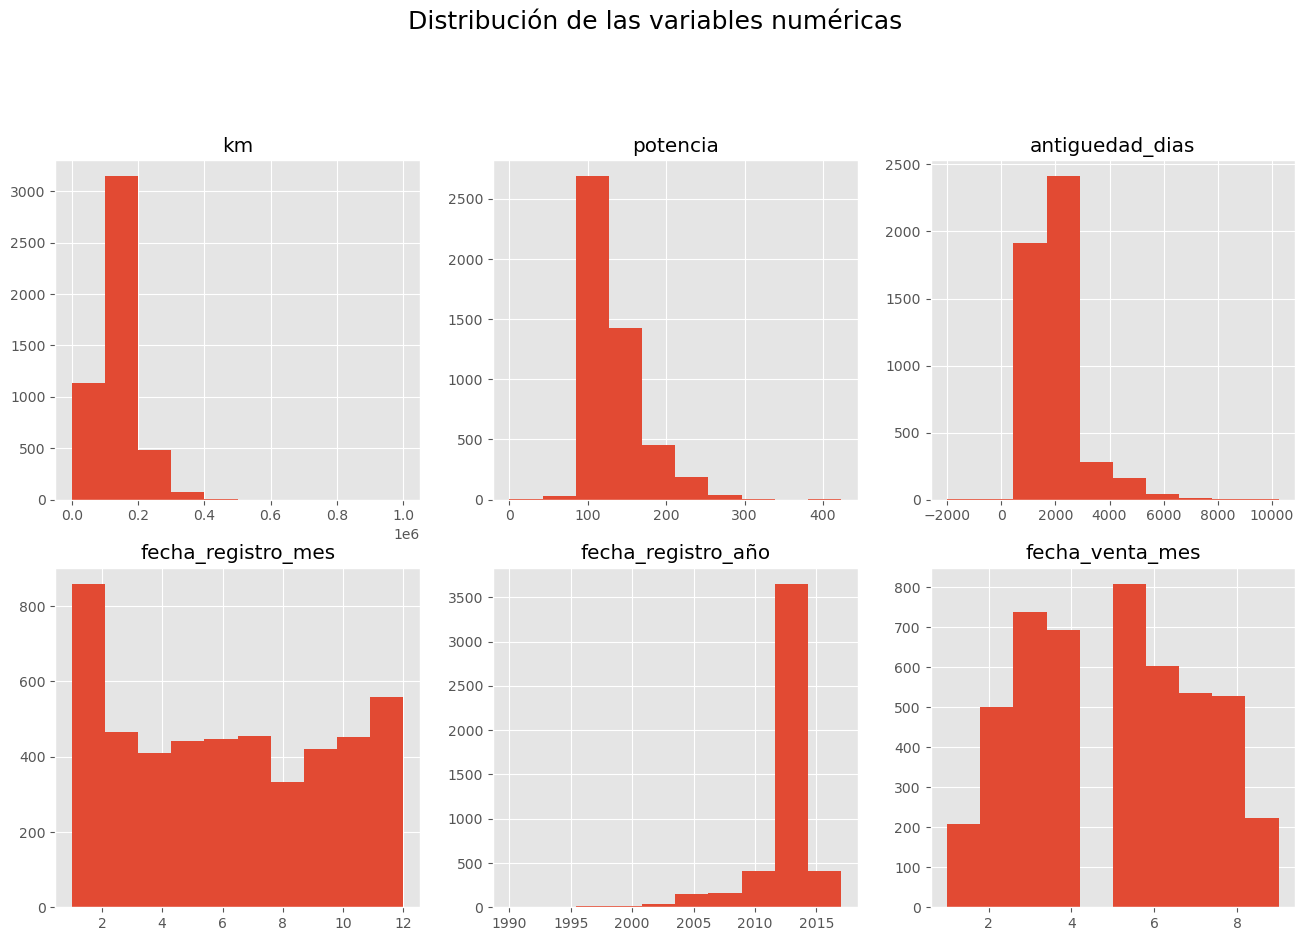

In [38]:
# instanciate the figure
fig = plt.figure(figsize = (16, 15))
for n, num in enumerate (list_num):
    fig.add_subplot(3, 3, n+1) # Indicamos número de filas y columnas
    bmw[num].hist()
    plt.title(num)

# create a title for the figure
fig.suptitle ('Distribución de las variables numéricas', fontsize = 18);

Vemos que el histograma de 'fecha_venta_mes' se divide en dos partes.\
Comprobamos que todos los meses tienen datos.

In [39]:
bmw['fecha_venta_mes'].value_counts()

5.00    809
3.00    738
4.00    693
6.00    604
7.00    537
8.00    528
2.00    502
9.00    223
1.00    208
Name: fecha_venta_mes, dtype: int64

Hay datos en los 9 meses durante los cuales tuvieron lugar las ventas

*Correlación entre variables numéricas*

In [40]:
corr = bmw.corr()
corr.style.background_gradient(cmap="coolwarm")

,km,potencia,gps,precio,antiguedad_dias,fecha_registro_mes,fecha_registro_año,fecha_venta_mes
km,1.000000,-0.050141,0.154815,-0.410189,0.499638,-0.017043,-0.507306,0.000164
potencia,-0.050141,1.000000,0.008862,0.639254,-0.083614,-0.000906,0.082524,-0.028098
gps,0.154815,0.008862,1.000000,-0.005227,0.077282,-0.016006,-0.072823,0.062770
precio,-0.410189,0.639254,-0.005227,1.000000,-0.441056,-0.016212,0.450352,0.012836
antiguedad_dias,0.499638,-0.083614,0.077282,-0.441056,1.000000,-0.041666,-0.985511,0.124039
fecha_registro_mes,-0.017043,-0.000906,-0.016006,-0.016212,-0.041666,1.000000,-0.070420,-0.016414
fecha_registro_año,-0.507306,0.082524,-0.072823,0.450352,-0.985511,-0.070420,1.000000,-0.053691
fecha_venta_mes,0.000164,-0.028098,0.062770,0.012836,0.124039,-0.016414,-0.053691,1.000000


Existe una correlación muy elevada entre "antiguedad_dias" y "fecha_registro_año", por lo que una de las dos variables la podemos eliminar.\
Considero que "antiguedad_dias" va a tener una mayor relevancia en el modelo.\
Eliminamos "fecha_registro_año".

In [41]:
del bmw['fecha_registro_año']

*Variables de baja varianza*

In [42]:
bmw = varianza_nula (dataframe = bmw)
bmw.head()

Se han borrado las siguientes variables numéricas por tener baja varianza:
 []


,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
0,118,"140,411.00",100.00,diesel,black,convertible,True,True,False,False,True,True,True,False,"11,300.00","2,161.00",2.00,1.00
1,M4,"13,929.00",317.00,petrol,grey,convertible,True,True,False,False,False,True,True,True,"69,700.00",671.00,4.00,2.00
2,320,"183,297.00",120.00,diesel,white,convertible,False,False,False,False,True,False,True,False,"10,200.00","2,132.00",4.00,2.00
3,420,"128,035.00",135.00,diesel,red,convertible,True,True,False,False,True,True,True,True,"25,100.00","1,311.00",7.00,2.00
4,425,"97,097.00",160.00,diesel,silver,convertible,True,True,False,False,False,True,True,True,"33,400.00","1,217.00",12.00,4.00


***Análisis de variables categóricas***

In [43]:
for i in list_cat:
  print(bmw[i].value_counts(),'\n')

320                  752
520                  633
318                  568
X3                   438
116                  358
X1                   274
316                  235
X5                   231
525                  184
530                  157
118                  143
318 Gran Turismo      97
320 Gran Turismo      73
518                   66
X4                    46
535                   46
420                   44
X6                    44
120                   36
420 Gran Coupé        33
330                   33
730                   33
520 Gran Turismo      23
325                   19
640 Gran Coupé        19
740                   18
530 Gran Turismo      18
X5 M                  17
114                   15
218 Active Tourer     13
M550                  12
218                   12
218 Gran Tourer        9
640                    8
418 Gran Coupé         8
X6 M                   8
M3                     7
335                    7
435 Gran Coupé         6
Z4                     6


***Análisis de variables booleanas***

In [44]:
for i in list_bool:
  print(bmw[i].value_counts(),'\n')

True     4514
False     329
Name: gps, dtype: int64 



***Análisis del target***

In [45]:
bmw['precio'].value_counts(dropna = False)

13,100.00    68
14,900.00    65
11,900.00    61
14,300.00    60
13,400.00    57
             ..
48,200.00     1
41,900.00     1
38,800.00     1
28,400.00     1
45,100.00     1
Name: precio, Length: 438, dtype: int64

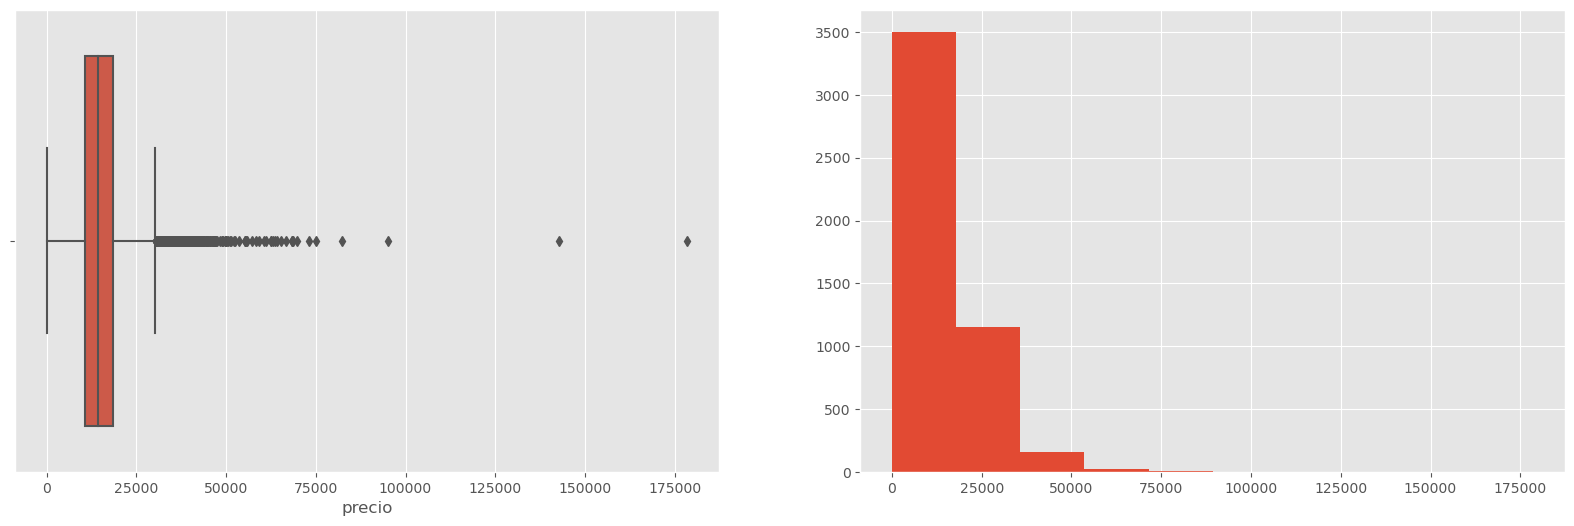

In [46]:
plot_target(dataframe = bmw, target = 'precio')

In [47]:
bmw[bmw['precio']<1000].sort_values('precio')

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
1832,116,"174,524.00",85.00,diesel,blue,hatchback,False,True,False,False,False,False,True,True,100.00,"1,339.00",7.00,3.00
4356,X3,"79,685.00",190.00,diesel,black,suv,False,False,False,False,False,False,False,True,100.00,"1,550.00",2.00,5.00
1255,320,"170,381.00",135.00,diesel,silver,estate,True,True,False,False,False,False,True,False,100.00,"1,765.00",7.00,5.00
879,318,"134,156.00",105.00,diesel,grey,estate,False,True,False,False,False,False,False,True,100.00,"1,400.00",6.00,4.00
2829,525,"439,060.00",105.00,diesel,silver,sedan,False,False,True,False,False,False,True,False,100.00,"7,821.00",10.00,3.00
630,318,"147,558.00",105.00,NaN,white,estate,False,True,False,False,False,False,False,True,100.00,"1,216.00",11.00,3.00
565,320,"179,358.00",120.00,diesel,black,estate,False,True,False,False,False,False,True,True,100.00,"1,734.00",6.00,3.00
2574,525,"229,880.00",85.00,diesel,black,sedan,False,False,False,False,False,False,True,False,200.00,"7,701.00",7.00,8.00
2611,525,"230,264.00",85.00,diesel,black,sedan,False,False,False,False,False,False,True,False,200.00,"7,701.00",7.00,8.00
2473,525,"230,578.00",85.00,diesel,black,sedan,False,False,False,False,False,False,True,False,200.00,"7,701.00",7.00,8.00


El target sigue una distribución de Skewed (está sesgada hacia la izquierda) --> **probamos a normalizarlo para que siga una distribución normal**

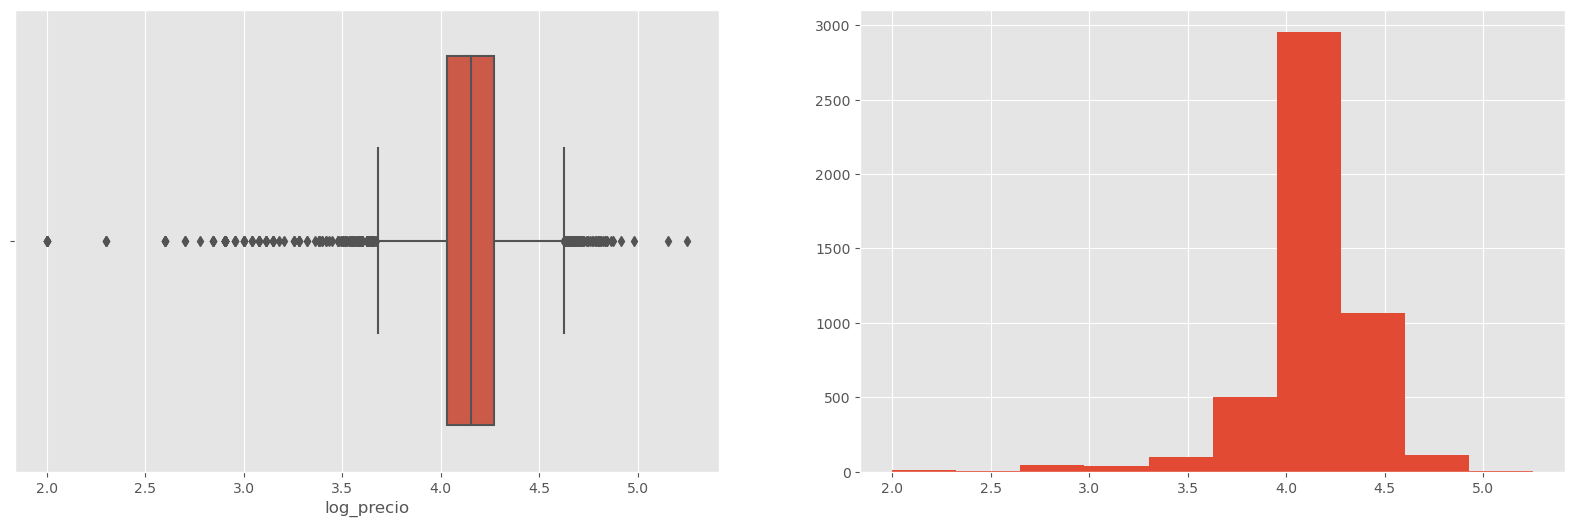

In [48]:
bmw['log_precio'] = np.log10(bmw['precio'])
plot_target(dataframe = bmw, target = 'log_precio')

Ahora tenemos una distribución sesgada hacia la derecha. No logramos tener una distribución normal.

In [49]:
# eliminamos log_precio
del bmw['log_precio']

### 2.2.- DISTRIBUCIÓN DE ATRIBUTOS Y CORRELACIÓN CON EL TARGET.
### *Target VS Variables independientes*

In [50]:
target = ['precio']

In [51]:
# Actualizamos listas
list_num, list_bool, list_cat = obtener_lista_variables(dataframe = bmw)

**A.- Variables numéricas**

In [52]:
list_num

['km', 'potencia', 'antiguedad_dias', 'fecha_registro_mes', 'fecha_venta_mes']


ANÁLISIS DE km CON RESPECTO AL precio

                len       min      mean       max
             precio    precio    precio    precio
km                                               
-64.00            1 75,000.00 75,000.00 75,000.00
476.00            1 30,300.00 30,300.00 30,300.00
612.00            1 49,100.00 49,100.00 49,100.00
706.00            1 41,600.00 41,600.00 41,600.00
2,399.00          1 17,300.00 17,300.00 17,300.00
...             ...       ...       ...       ...
405,816.00        1    500.00    500.00    500.00
439,060.00        1    100.00    100.00    100.00
477,571.00        1  1,200.00  1,200.00  1,200.00
484,615.00        1  8,300.00  8,300.00  8,300.00
1,000,376.00      1  1,400.00  1,400.00  1,400.00

[4784 rows x 4 columns]


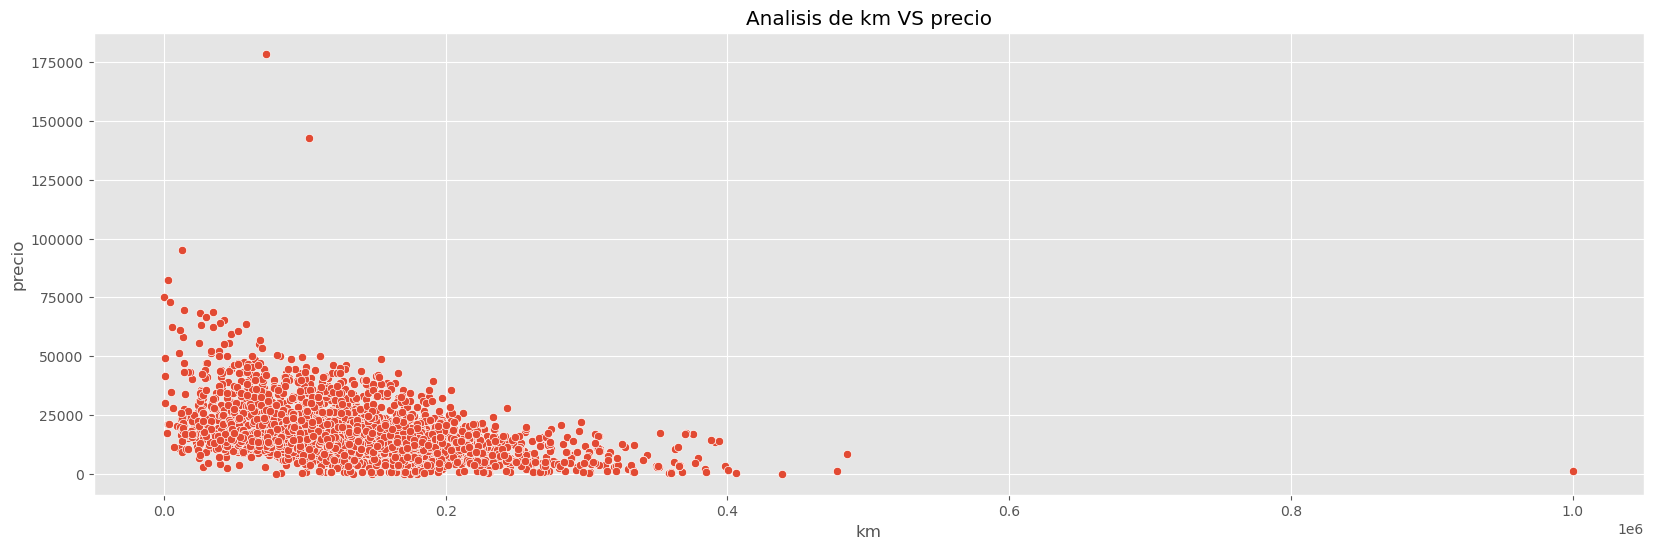


ANÁLISIS DE potencia CON RESPECTO AL precio

            len       min      mean        max
         precio    precio    precio     precio
potencia                                      
0.00          1 11,700.00 11,700.00  11,700.00
25.00         2 15,500.00 17,900.00  20,300.00
66.00         2  1,000.00  1,150.00   1,300.00
70.00        11  6,200.00 11,127.27  17,800.00
75.00         9    400.00 14,844.44  28,000.00
77.00         3    400.00    633.33     800.00
80.00         4 13,400.00 17,350.00  21,700.00
85.00       631    100.00  9,948.89  21,400.00
87.00         6    700.00 10,200.00  15,000.00
90.00        40  1,400.00  4,290.00   8,100.00
95.00         3  3,600.00  4,300.00   5,500.00
100.00      570    400.00 11,903.16  31,000.00
101.00        2  7,900.00  8,150.00   8,400.00
105.00      451    100.00 12,359.65  31,100.00
107.00        3  8,800.00 13,933.33  18,100.00
110.00      142    700.00 11,308.45  31,100.00
112.00        5 11,800.00 14,800.00  19,600.00
119.00        

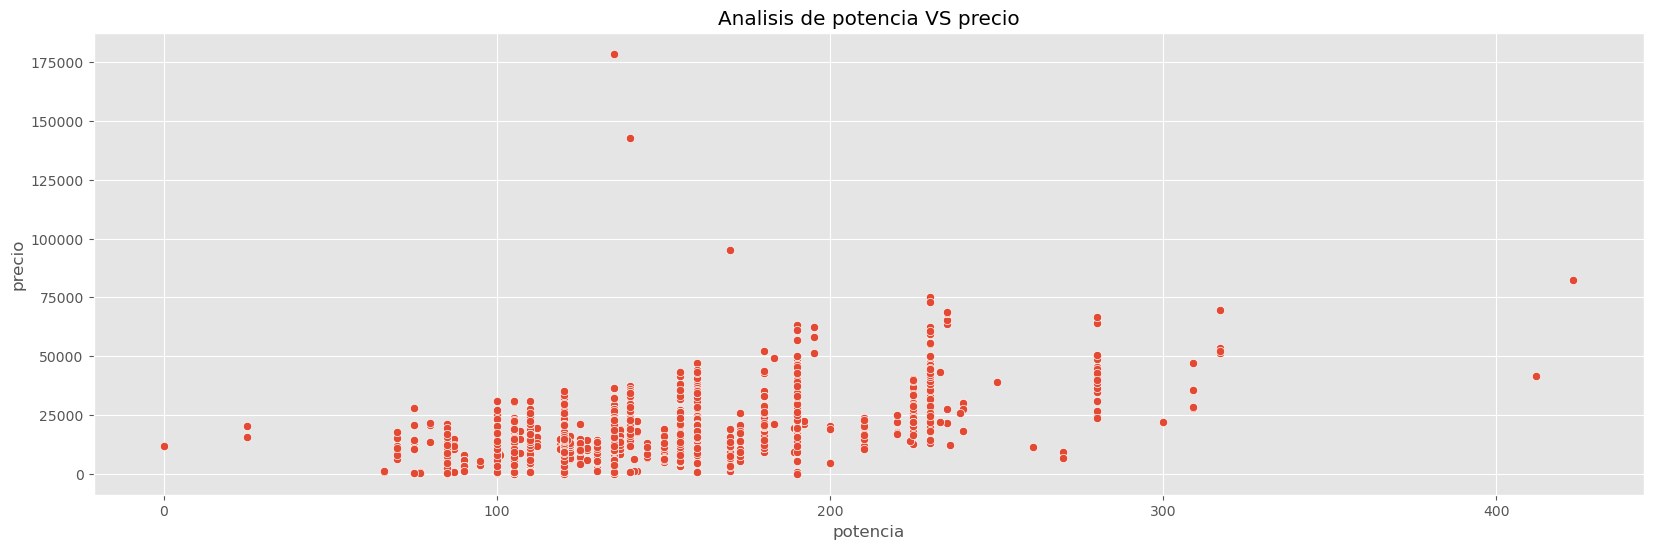


ANÁLISIS DE antiguedad_dias CON RESPECTO AL precio

                   len       min      mean       max
                precio    precio    precio    precio
antiguedad_dias                                     
-2,009.00            2  8,800.00 10,150.00 11,500.00
-1,614.00            1 15,800.00 15,800.00 15,800.00
-609.00              1  8,200.00  8,200.00  8,200.00
215.00               1 41,600.00 41,600.00 41,600.00
273.00               1 11,300.00 11,300.00 11,300.00
...                ...       ...       ...       ...
7,821.00             2    100.00    500.00    900.00
8,035.00             1 12,100.00 12,100.00 12,100.00
8,248.00             1  1,800.00  1,800.00  1,800.00
8,856.00             1    400.00    400.00    400.00
10,258.00            1  1,300.00  1,300.00  1,300.00

[460 rows x 4 columns]


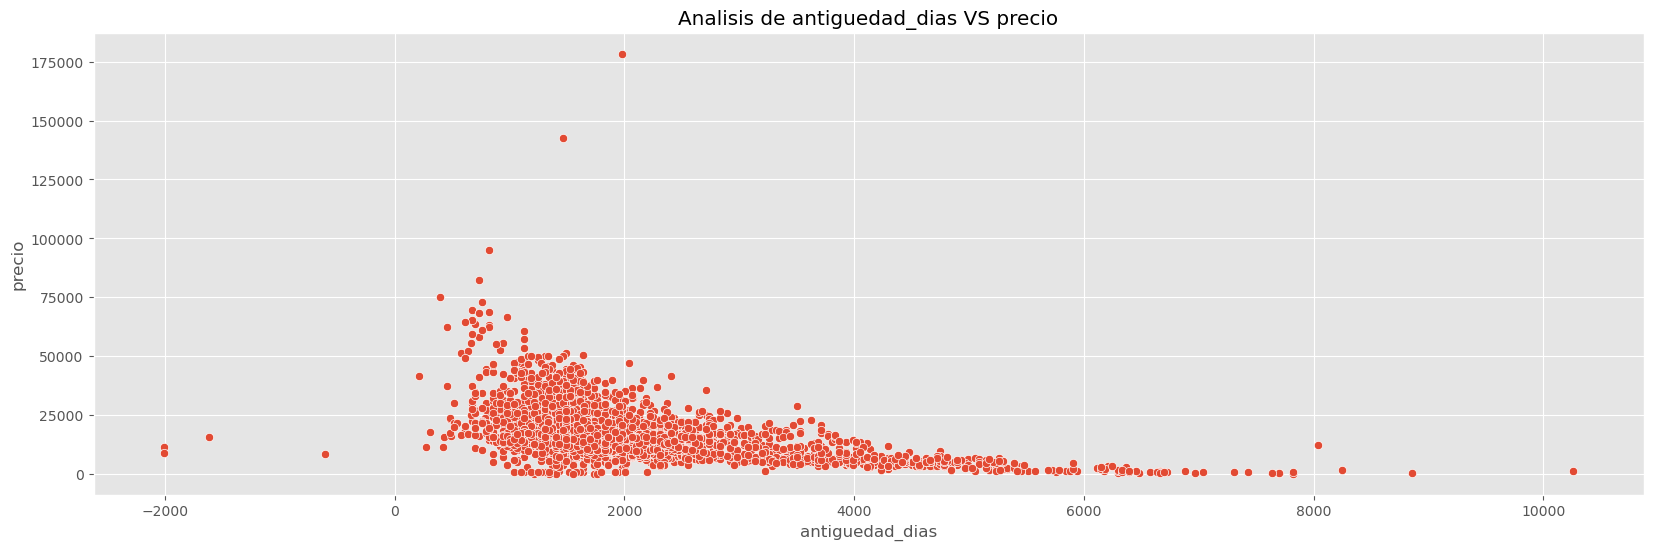


ANÁLISIS DE fecha_registro_mes CON RESPECTO AL precio

                      len    min      mean        max
                   precio precio    precio     precio
fecha_registro_mes                                   
1.00                  463 400.00 15,751.40  95,200.00
2.00                  396 100.00 15,826.52  57,100.00
3.00                  466 800.00 16,559.44 178,500.00
4.00                  410 800.00 16,952.93  82,400.00
5.00                  441 800.00 15,688.38  64,300.00
6.00                  447 100.00 14,834.00  68,700.00
7.00                  455 100.00 15,820.97  73,100.00
8.00                  333 800.00 15,376.58 142,800.00
9.00                  419 400.00 16,288.52  55,700.00
10.00                 453 100.00 15,306.18  49,700.00
11.00                 348 100.00 15,204.61  62,500.00
12.00                 211 800.00 16,667.77  66,600.00


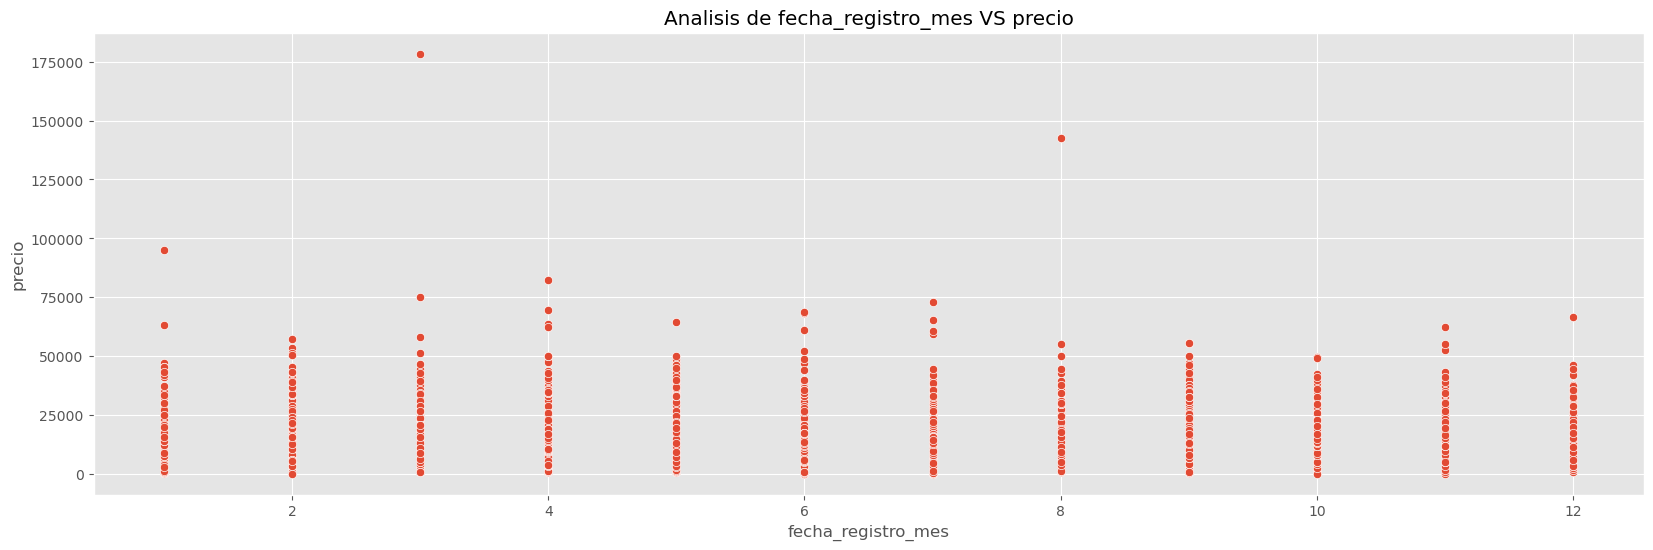


ANÁLISIS DE fecha_venta_mes CON RESPECTO AL precio

                   len    min      mean        max
                precio precio    precio     precio
fecha_venta_mes                                   
1.00               208 600.00 14,908.65  64,300.00
2.00               502 700.00 16,056.40  69,700.00
3.00               738 100.00 15,600.14  63,700.00
4.00               693 100.00 16,038.24  95,200.00
5.00               809 100.00 16,049.63  65,400.00
6.00               604 700.00 15,331.29  68,300.00
7.00               537 400.00 15,411.36  62,500.00
8.00               528 200.00 16,827.27 178,500.00
9.00               223 700.00 15,587.89  68,700.00


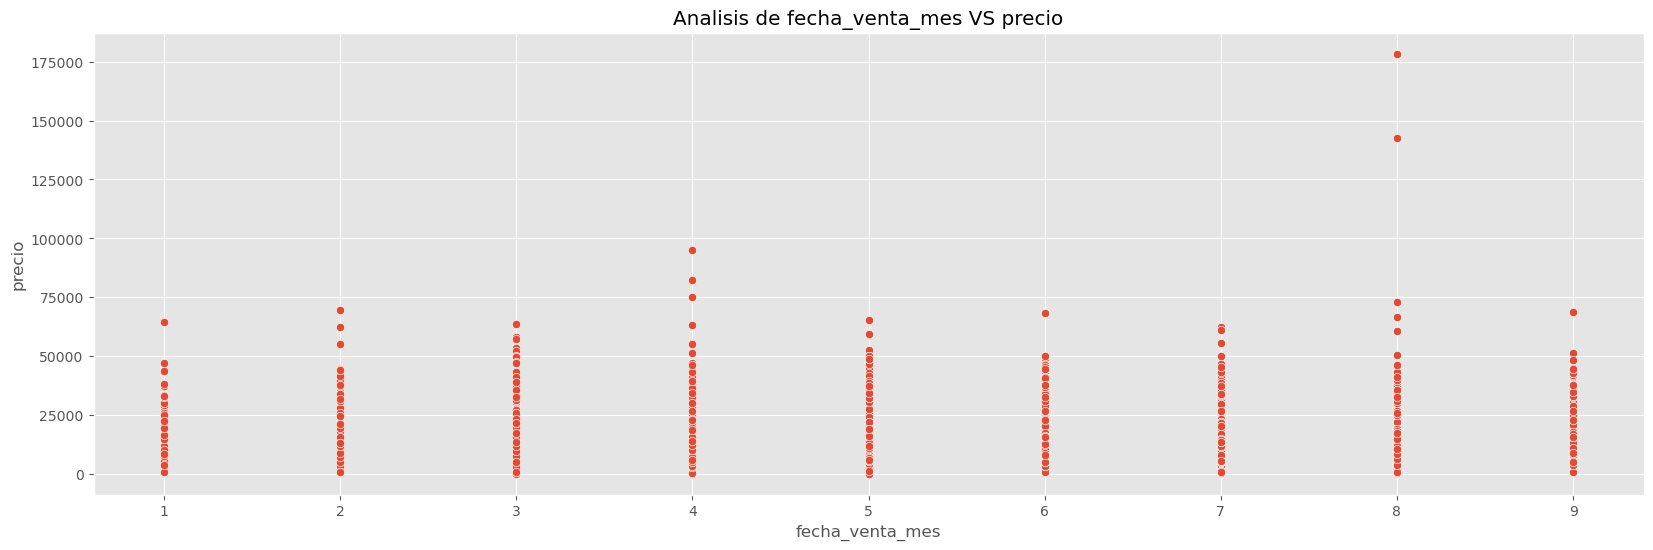

In [53]:
for var in list_num:
    print(analisis_numericas (dataframe = bmw, column = var, target = 'precio'))
    plot_numericas(dataframe = bmw, column = var, target = 'precio')

- El precio disminuye al aumentar los km.
- El precio aumenta al aumentar la potencia.
- El precio disminuye al aumentar la antigüedad.

Por lo tanto, las tres variables son relevantes para predecir el precio del vehículo.

**B.- Variables Categóricas**

In [54]:
list_cat

['modelo',
 'tipo_gasolina',
 'color',
 'tipo_coche',
 'volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'asientos_traseros_plegables',
 'elevalunas_electrico',
 'bluetooth',
 'alerta_lim_velocidad']

In [55]:
# SE PODRÍA HACER TAMBIÉN CON UN GROUPBY
bmw.groupby('color')['precio'].agg([len, min, np.mean, max]).sort_values(by='color',ascending=False)

,len,min,mean,max
color,,,,
white,537,100.00,"17,314.37","66,600.00"
silver,327,100.00,"14,826.30","73,100.00"
red,51,"2,400.00","16,568.63","82,400.00"
orange,6,"13,100.00","18,866.67","28,300.00"
grey,1171,100.00,"15,619.91","142,800.00"
green,18,700.00,"7,200.00","20,500.00"
brown,341,800.00,"15,367.74","46,500.00"
blue,707,100.00,"15,137.78","178,500.00"
black,1632,100.00,"16,178.48","75,000.00"



ANÁLISIS DE modelo CON RESPECTO AL precio

                     len       min      mean        max
                  precio    precio    precio     precio
modelo                                                 
320                  752    100.00 12,173.07  25,800.00
520                  633    400.00 15,713.29  28,800.00
318                  568    100.00 10,982.19  30,600.00
X3                   438    100.00 18,175.80 178,500.00
116                  358    100.00  9,653.91  21,700.00
X1                   274    600.00 12,691.97  25,800.00
316                  235    400.00 10,367.95  20,300.00
X5                   231  3,000.00 30,570.13  55,700.00
525                  184    100.00 15,363.04  34,900.00
530                  157  1,300.00 19,826.11  62,500.00
118                  143    800.00  9,647.55  24,400.00
318 Gran Turismo      97  9,200.00 14,854.64  23,800.00
320 Gran Turismo      73 11,900.00 17,745.21  25,900.00
518                   66  8,800.00 16,489.39  27,100.00
535 

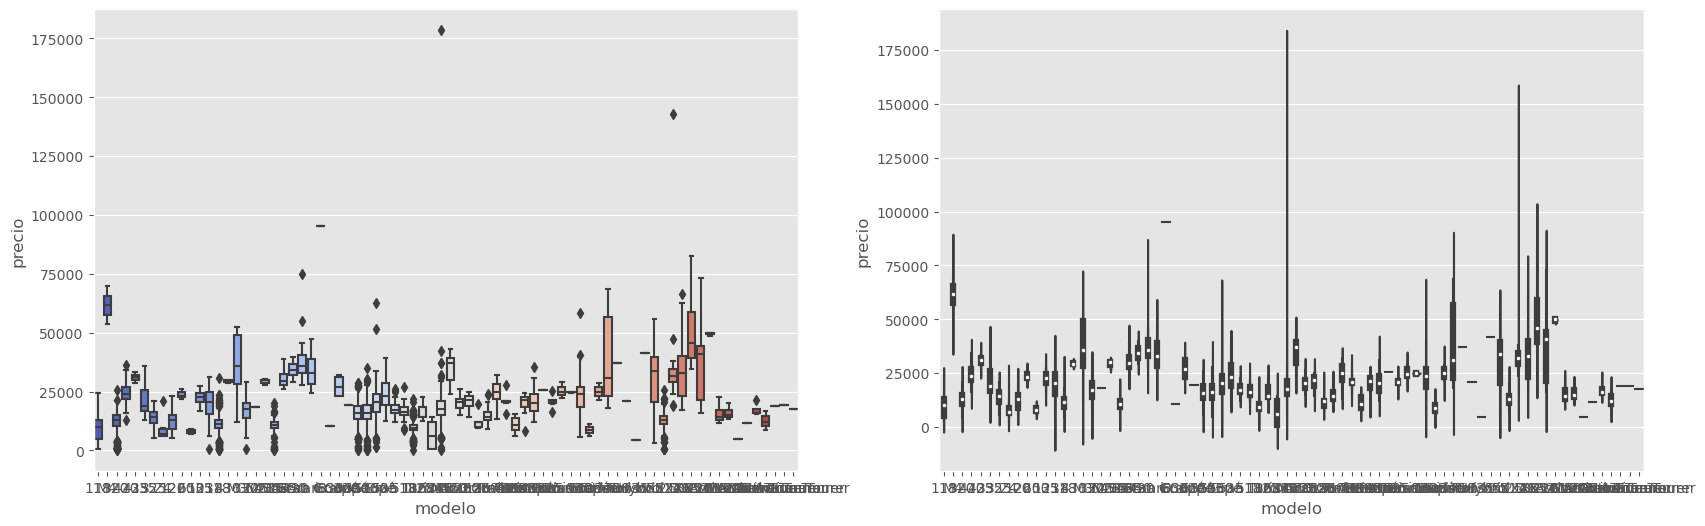


ANÁLISIS DE tipo_gasolina CON RESPECTO AL precio

                 len       min      mean        max
              precio    precio    precio     precio
tipo_gasolina                                      
diesel          4631    100.00 15,859.26 178,500.00
petrol           191    400.00 14,398.43  82,400.00
hybrid_petrol      8 15,500.00 37,575.00  95,200.00
Diesel             5  6,500.00 13,960.00  23,100.00
electro            3 20,800.00 20,966.67  21,200.00


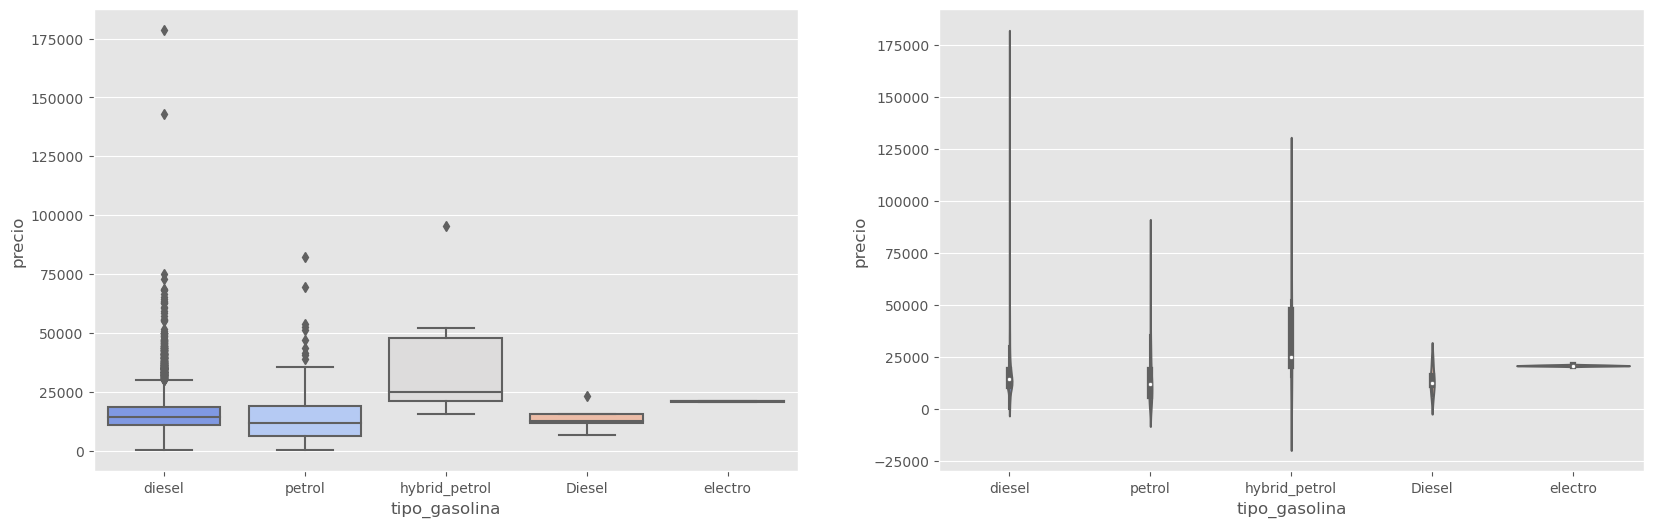


ANÁLISIS DE color CON RESPECTO AL precio

          len       min      mean        max
       precio    precio    precio     precio
color                                       
black    1632    100.00 16,178.48  75,000.00
grey     1171    100.00 15,619.91 142,800.00
blue      707    100.00 15,137.78 178,500.00
white     537    100.00 17,314.37  66,600.00
brown     341    800.00 15,367.74  46,500.00
silver    327    100.00 14,826.30  73,100.00
red        51  2,400.00 16,568.63  82,400.00
beige      41  7,700.00 15,817.07  32,100.00
green      18    700.00  7,200.00  20,500.00
orange      6 13,100.00 18,866.67  28,300.00


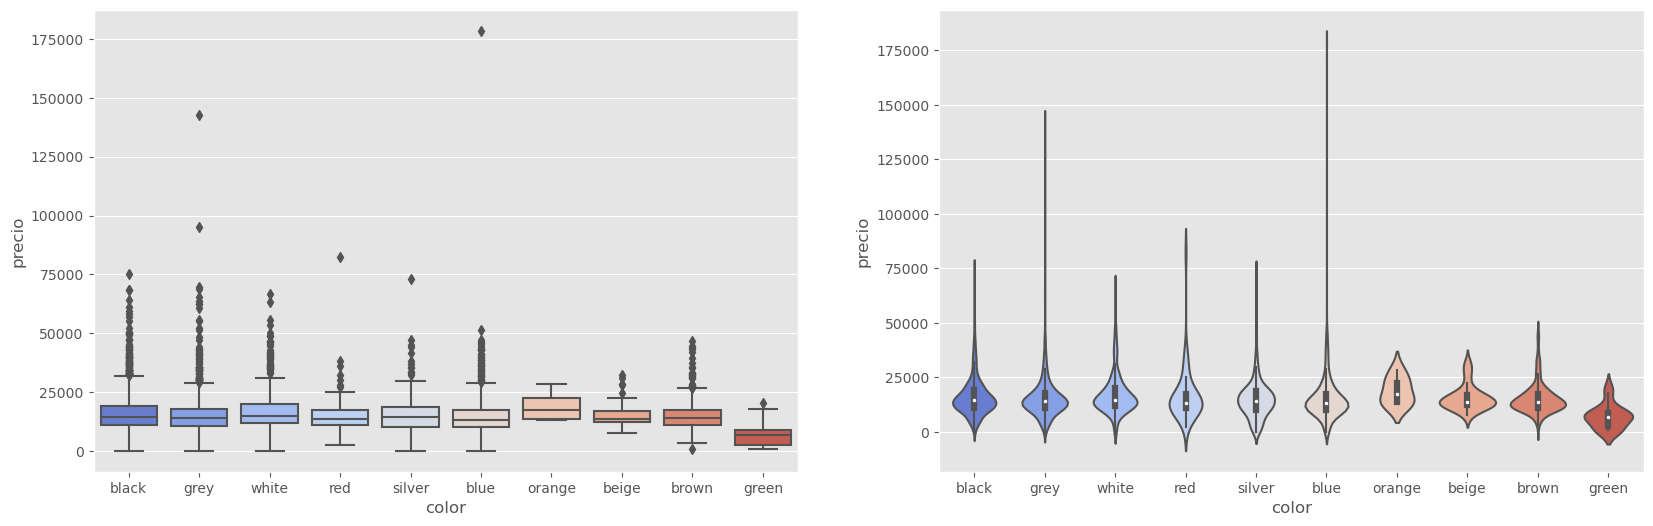


ANÁLISIS DE tipo_coche CON RESPECTO AL precio

               len      min      mean        max
            precio   precio    precio     precio
tipo_coche                                      
estate        1604   100.00 13,126.33  40,900.00
sedan         1167   100.00 16,021.94  75,000.00
suv           1057   100.00 21,500.47 178,500.00
hatchback      699   100.00 13,289.41  40,500.00
subcompact     113 1,100.00  9,687.61  28,000.00
coupe          104 1,000.00 22,169.90  95,200.00
convertible     47 1,800.00 17,136.17  69,700.00
van             43   800.00 14,323.26  22,800.00


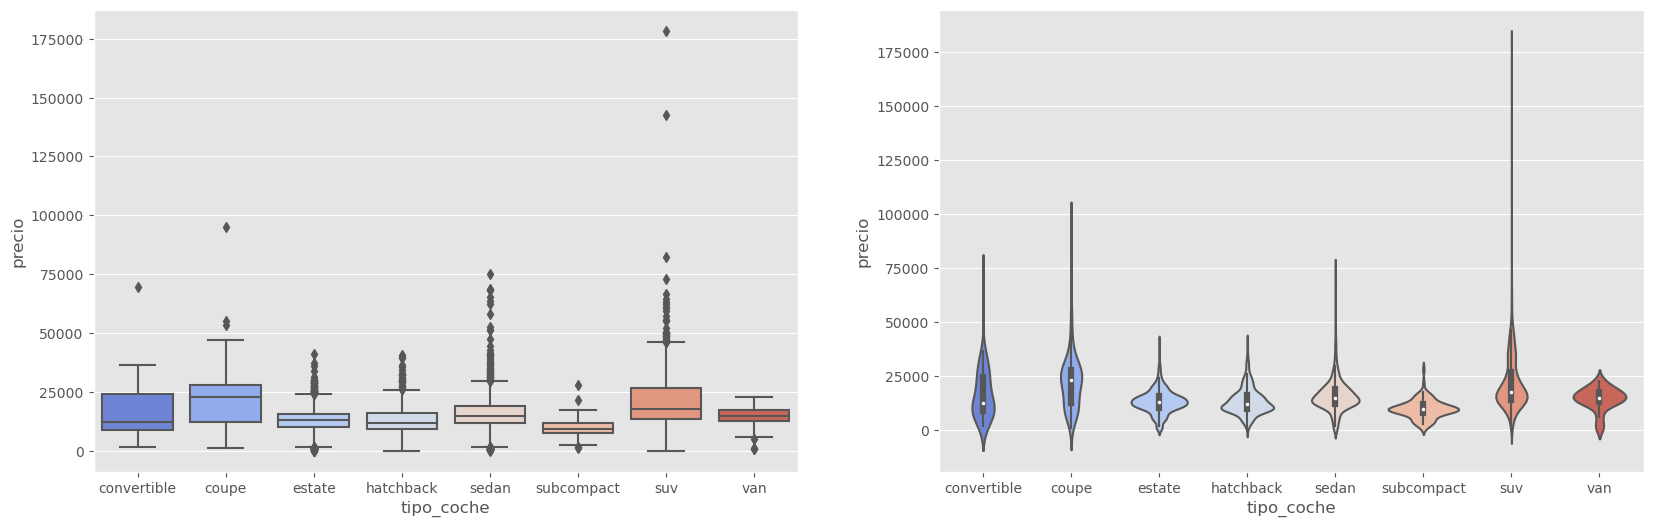


ANÁLISIS DE volante_regulable CON RESPECTO AL precio

                     len    min      mean        max
                  precio precio    precio     precio
volante_regulable                                   
True                2662 100.00 18,079.23 142,800.00
False               2177 100.00 13,096.74 178,500.00


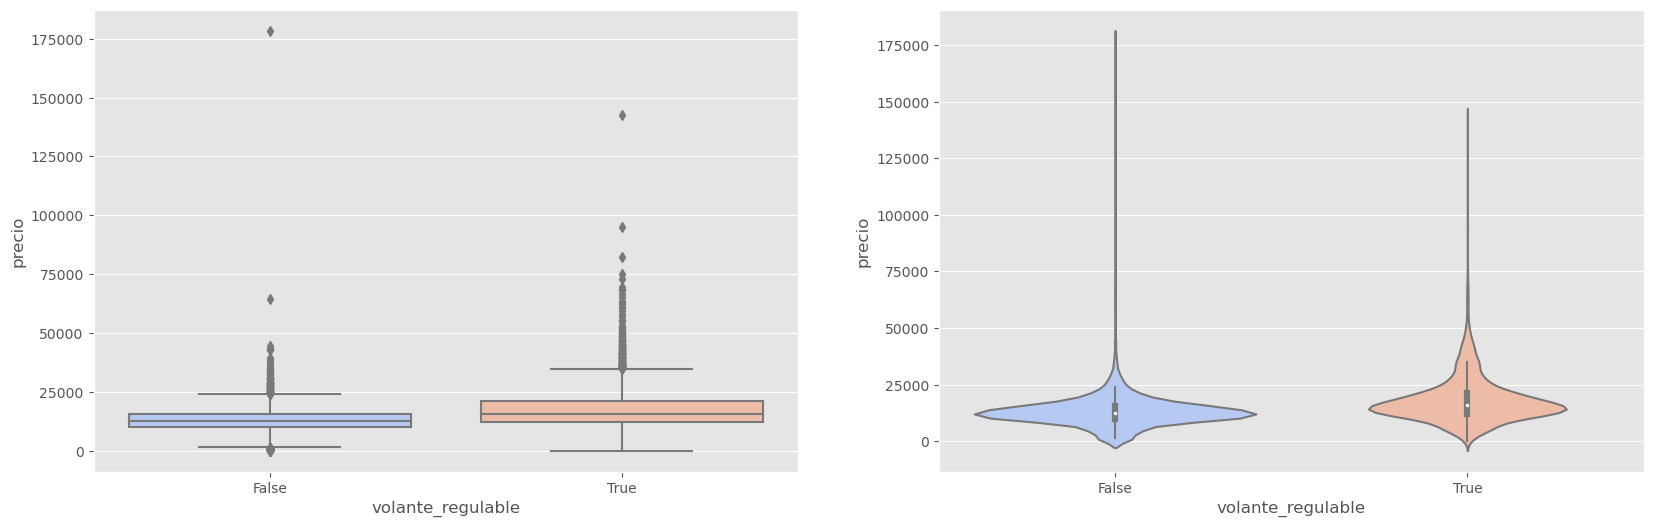


ANÁLISIS DE aire_acondicionado CON RESPECTO AL precio

                      len    min      mean        max
                   precio precio    precio     precio
aire_acondicionado                                   
True                 3837 100.00 16,998.12 142,800.00
False                1004 100.00 11,376.47 178,500.00


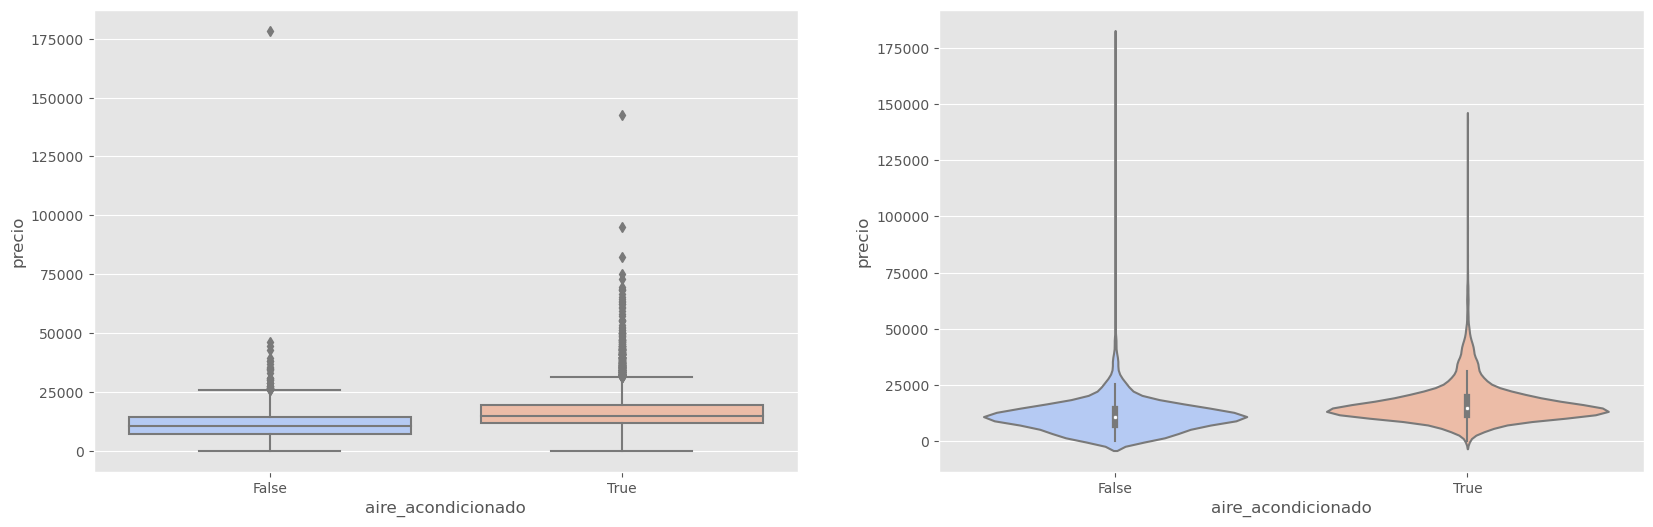


ANÁLISIS DE camara_trasera CON RESPECTO AL precio

                  len    min      mean        max
               precio precio    precio     precio
camara_trasera                                   
False            3864 100.00 14,667.31 142,800.00
True              977 100.00 20,453.70 178,500.00


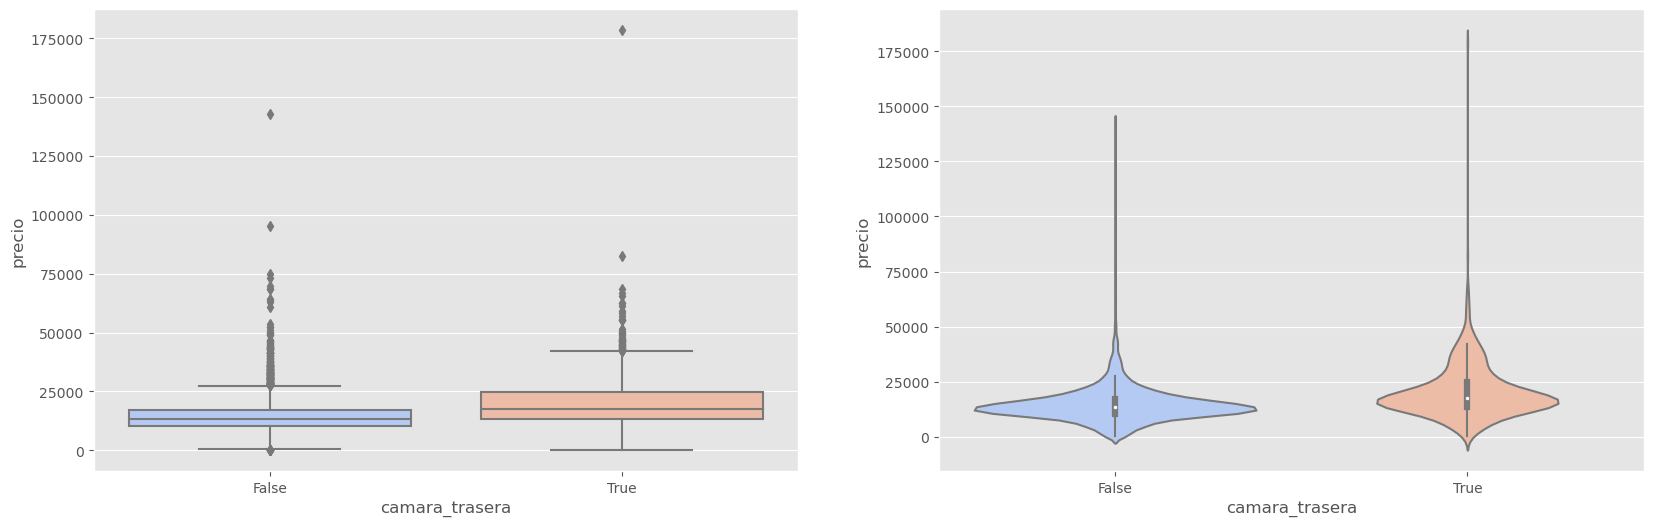


ANÁLISIS DE asientos_traseros_plegables CON RESPECTO AL precio

                               len      min      mean        max
                            precio   precio    precio     precio
asientos_traseros_plegables                                     
False                         3877   100.00 13,928.00 178,500.00
True                           962 3,600.00 23,501.56  75,000.00


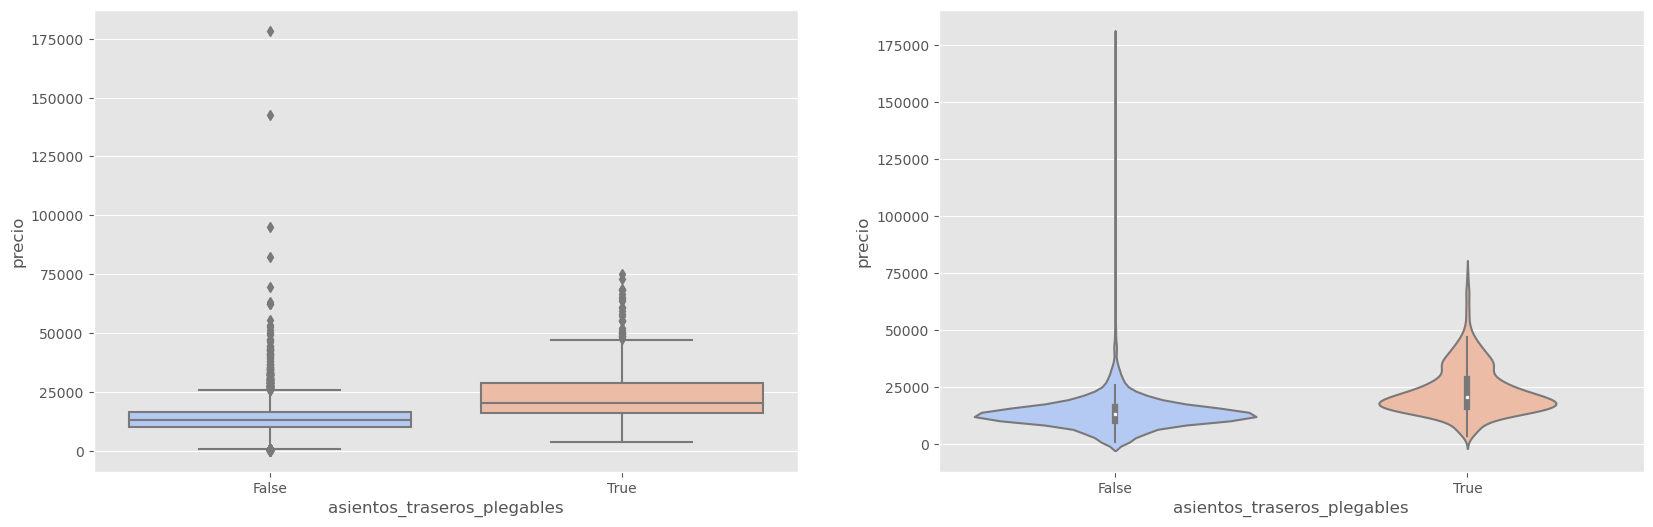


ANÁLISIS DE elevalunas_electrico CON RESPECTO AL precio

                        len    min      mean        max
                     precio precio    precio     precio
elevalunas_electrico                                   
False                  2612 100.00 13,597.89 178,500.00
True                   2229 400.00 18,435.31 142,800.00


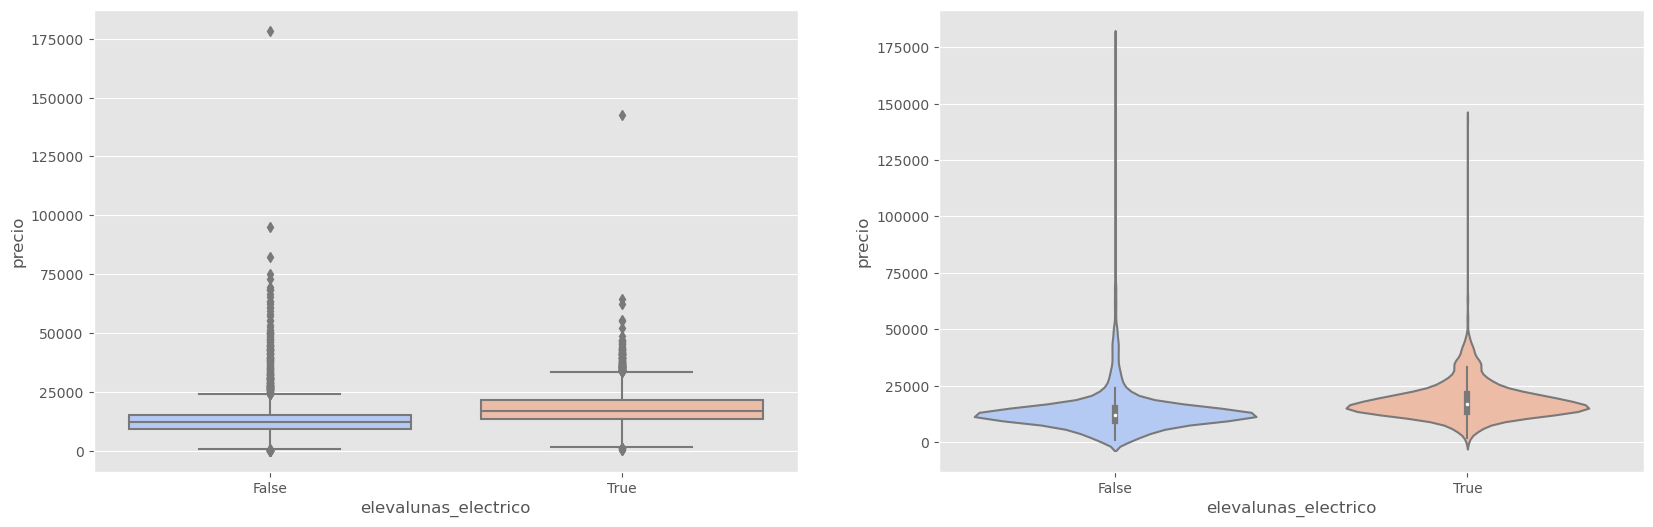


ANÁLISIS DE bluetooth CON RESPECTO AL precio

             len    min      mean        max
          precio precio    precio     precio
bluetooth                                   
False       3670 100.00 14,743.45 178,500.00
True        1169 700.00 19,277.12  69,700.00


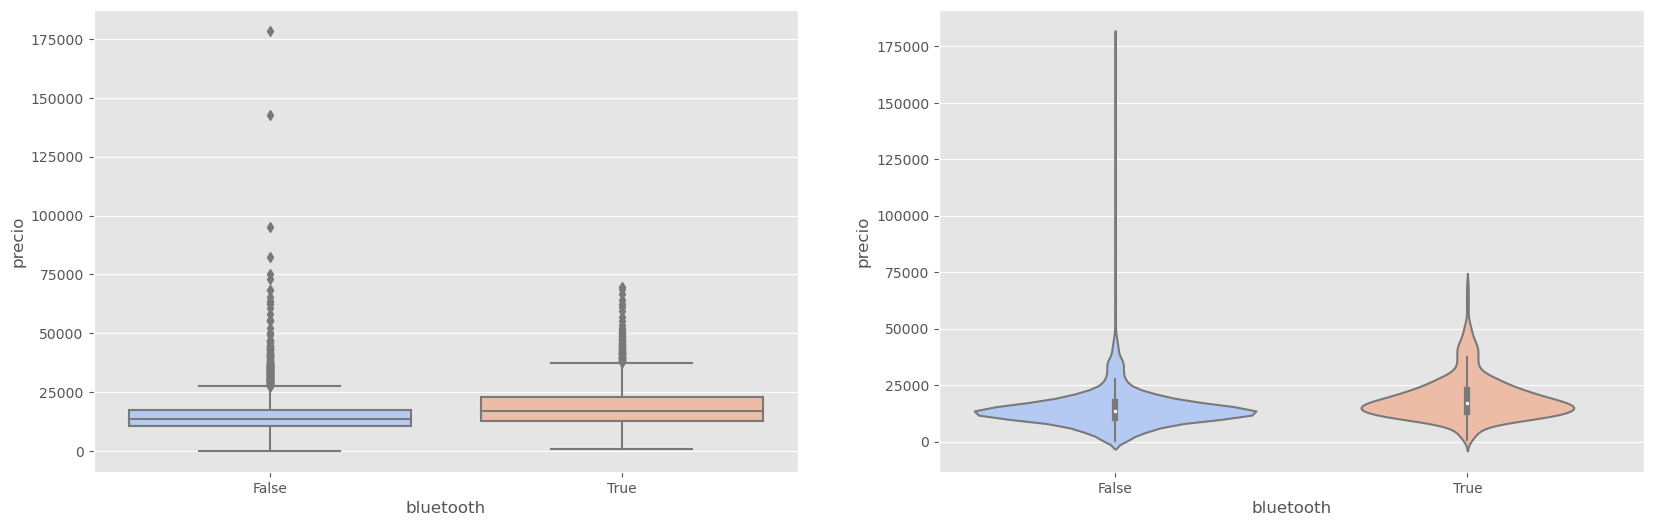


ANÁLISIS DE alerta_lim_velocidad CON RESPECTO AL precio

                        len    min      mean        max
                     precio precio    precio     precio
alerta_lim_velocidad                                   
True                   2618 100.00 19,603.14 178,500.00
False                  2223 100.00 11,395.99  64,300.00


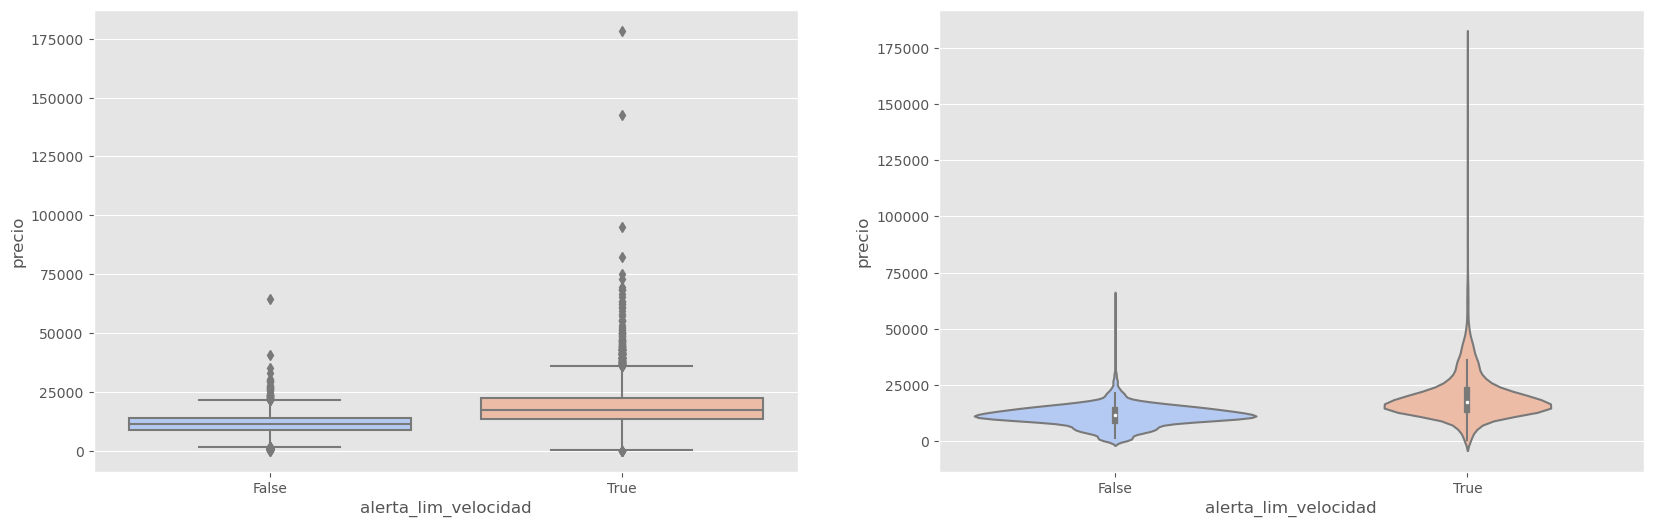

In [56]:
for var in list_cat:
    print(analisis_categoricas (dataframe = bmw, column = var, target = 'precio'))
    plot_categoricas(dataframe = bmw, column = var, target = 'precio')

In [57]:
bmw['modelo'].value_counts()

320                  752
520                  633
318                  568
X3                   438
116                  358
X1                   274
316                  235
X5                   231
525                  184
530                  157
118                  143
318 Gran Turismo      97
320 Gran Turismo      73
518                   66
X4                    46
535                   46
420                   44
X6                    44
120                   36
420 Gran Coupé        33
330                   33
730                   33
520 Gran Turismo      23
325                   19
640 Gran Coupé        19
740                   18
530 Gran Turismo      18
X5 M                  17
114                   15
218 Active Tourer     13
M550                  12
218                   12
218 Gran Tourer        9
640                    8
418 Gran Coupé         8
X6 M                   8
M3                     7
335                    7
435 Gran Coupé         6
Z4                     6


Se agrupan todos los modelos 'gran turismo' y los 'gran coupé

In [58]:
for i in ['gran turismo', 'gran coupé']:
    bmw['modelo'] = np.where(bmw['modelo'].str.contains(i, na = False, case = False, regex = False), i, bmw['modelo'])

Agrupamos en 'others' aquellos modelos que tengan menos de 70 unidades vendidas

In [59]:
setOthers(dataframe = bmw, column = 'modelo', num_values = 13)

In [60]:
bmw['modelo'].value_counts()

320             752
520             633
Others          577
318             568
X3              438
116             358
X1              274
316             235
X5              231
gran turismo    223
525             184
530             157
118             143
gran coupé       70
Name: modelo, dtype: int64

Vemos con más detenimiento el color y el tipo de gasolina, porque parece que no tienen relevancia en el precio

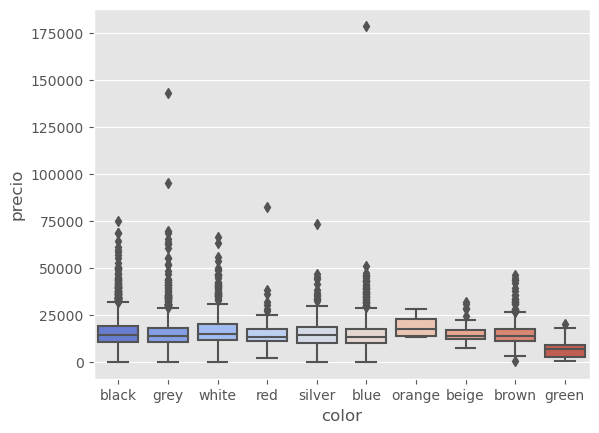

In [61]:
sns.boxplot(x='color', y='precio', data= bmw, palette="coolwarm");

In [62]:
bmw['color'].value_counts()

black     1632
grey      1171
blue       707
white      537
brown      341
silver     327
red         51
beige       41
green       18
orange       6
Name: color, dtype: int64

Los colores que realmente influyen en el precio del vehículo son el orange y el green. 

Pero debido a las pocas únidades vendidas de esos vehículos, no nos va a aportar información relevante.

Podemos prescindir de la variable 'color'

In [63]:
del bmw['color']

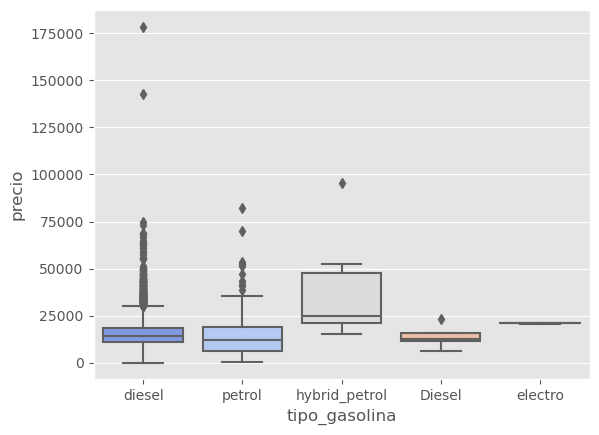

In [64]:
sns.boxplot(x='tipo_gasolina', y='precio', data= bmw, palette="coolwarm");

In [65]:
bmw['tipo_gasolina'].value_counts()

diesel           4631
petrol            191
hybrid_petrol       8
Diesel              5
electro             3
Name: tipo_gasolina, dtype: int64

Se renombra Diesel por diesel y se reducen las etiquetas a 2.

In [66]:
bmw['tipo_gasolina'] = np.where(bmw['tipo_gasolina']=='Diesel', 'diesel', bmw['tipo_gasolina'])

In [67]:
# Nos quedamos con los vehículos que tienen "diesel" y "petrol"
setOthers(dataframe = bmw, column = 'tipo_gasolina', num_values = 2)

**C.- Variables booleanas**


ANÁLISIS DE gps CON RESPECTO AL precio

         len    min      mean        max
      precio precio    precio     precio
gps                                     
True    4514 100.00 15,818.90 142,800.00
False    329 100.00 16,010.33 178,500.00


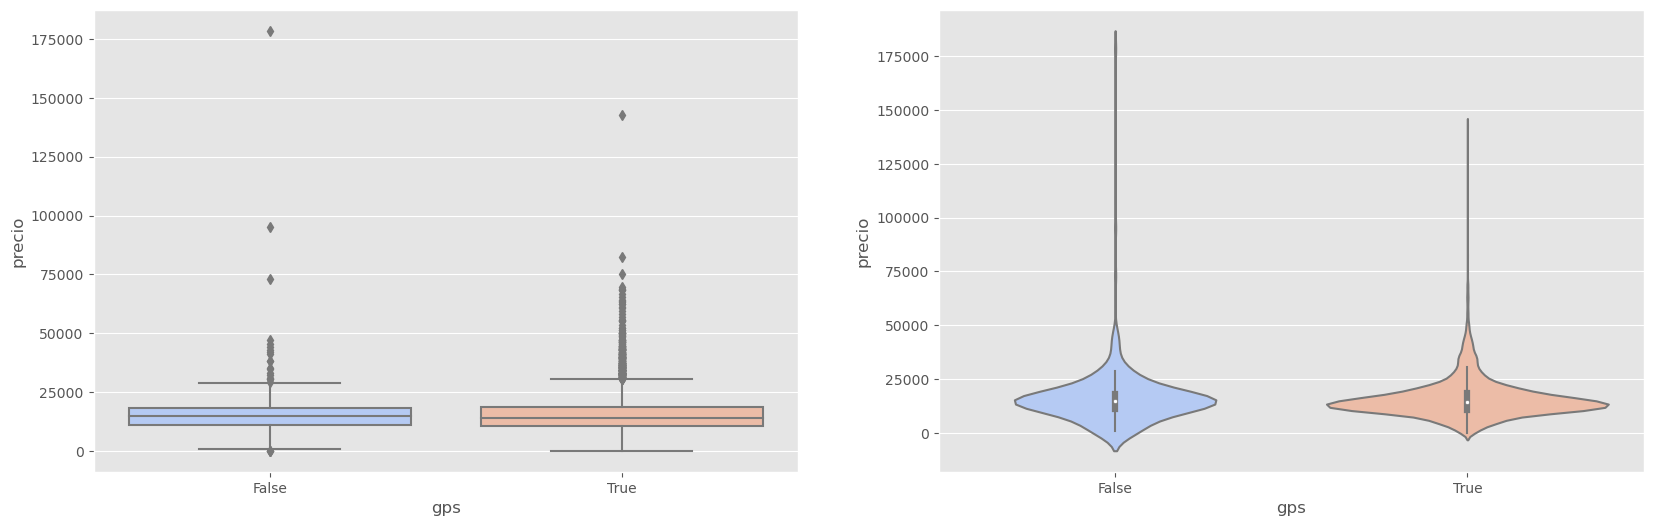

In [68]:
for var in list_bool:
    print(analisis_booleanas (dataframe = bmw, column = var, target = 'precio'))
    plot_booleanas(dataframe = bmw, column = var, target = 'precio')

In [69]:
bmw['gps'].sum()/len(bmw['gps'])*100

93.20669006813958

Podemos ver que el gps tiene muy poca incidencia en el precio.

Además, el 93% de los vehículos tienen gps, por lo que podemos eliminar esta variable.

In [70]:
del bmw['gps']

## **3.- DATA PREPARATION**

### 3.1.- IMPUTACIÓN DE NULOS

In [71]:
nulos_variable (bmw)

Las variables numéricas que tienen nulos son:
 km                    2
potencia              1
precio                6
antiguedad_dias       2
fecha_registro_mes    1
fecha_venta_mes       1
dtype: int64 

Hay un total de 6 variables numéricas con nulos


Las variables categóricas que tienen nulos son:
 tipo_coche                     9
volante_regulable              4
aire_acondicionado             2
camara_trasera                 2
asientos_traseros_plegables    4
elevalunas_electrico           2
bluetooth                      4
alerta_lim_velocidad           2
dtype: int64 

Hay un total de 8 variables categóricas con nulos


VARIABLES TOTALES CON NULOS: 14


**A.- Variables numéricas**

***km***

In [72]:
bmw[bmw['km'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
459,520,NaN,135.00,diesel,estate,True,True,True,False,True,True,True,"20,300.00","1,888.00",12.00,2.00
4811,X3,NaN,190.00,diesel,van,True,True,True,True,True,False,True,"19,500.00","1,703.00",11.00,7.00


No es posible determinar los km de los vehículos, por lo que para evitar ruido al modelo, elimino los dos registros

In [73]:
bmw.drop(bmw[bmw['km'].isnull()].index.to_list(), axis = 0, inplace = True)

***potencia***

In [74]:
bmw[bmw['potencia'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
181,525,"106,054.00",NaN,diesel,estate,False,True,False,False,False,False,True,"18,700.00","1,400.00",5.00,3.00


Vemos las características de los vehículos parecidos al del registro 181

In [75]:
bmw[(bmw["modelo"]=='525') & (bmw["tipo_gasolina"]=='diesel') & (bmw["tipo_coche"]=='estate')].describe()

,km,potencia,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
count,105.00,104.00,105.00,104.00,105.00,104.00
mean,"176,018.44",152.16,"14,694.29","2,322.00",6.20,4.62
std,"66,269.80",12.71,"6,268.05","1,153.17",3.12,1.99
min,"21,507.00",120.00,800.00,518.00,1.00,1.00
25%,"125,242.00",150.00,"12,600.00","1,581.00",4.00,3.00
50%,"169,163.00",160.00,"15,500.00","1,976.50",6.00,4.00
75%,"223,394.00",160.00,"18,600.00","2,633.00",9.00,6.00
max,"398,043.00",160.00,"30,200.00","6,179.00",12.00,9.00


In [76]:
bmw[(bmw["modelo"]=='525') & (bmw["tipo_gasolina"]=='diesel') & (bmw["tipo_coche"]=='estate')]['potencia'].value_counts()

160.00    57
150.00    15
155.00    14
120.00    10
130.00     5
145.00     3
Name: potencia, dtype: int64

La mayoría de los vehículos tienen una potencia de 160.\
Sustituimos el nulo por 160

In [77]:
bmw['potencia'].fillna(160, inplace = True)

***antiguedad_dias***

In [78]:
bmw[bmw['antiguedad_dias'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
198,318,"158,853.00",100.00,diesel,estate,True,False,False,False,False,False,False,"10,900.00",NaN,NaN,6.00
594,525,"269,290.00",120.00,diesel,estate,True,False,True,False,False,False,True,"4,200.00",NaN,6.00,NaN


No es posible determinar los días de antigüedad de los vehículos, por lo que para evitar ruido al modelo, elimino los dos registros

In [79]:
bmw.drop (bmw[bmw['antiguedad_dias'].isnull()].index.to_list(), axis = 0, inplace = True)

***precio***

In [80]:
bmw[bmw['precio'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
117,Others,"174,740.00",135.00,diesel,coupe,True,True,True,False,True,True,True,NaN,"1,642.00",11.00,5.00
524,520,"163,803.00",135.00,diesel,estate,False,True,True,False,False,False,False,NaN,"1,676.00",7.00,2.00
539,316,"34,489.00",85.00,diesel,estate,True,False,False,False,False,False,False,NaN,"1,676.00",7.00,2.00
549,318,"157,129.00",100.00,diesel,estate,True,True,True,False,True,False,True,NaN,"1,642.00",9.00,3.00
569,320,"166,866.00",120.00,diesel,estate,True,True,False,False,True,True,True,NaN,"1,400.00",5.00,3.00
584,320,"114,771.00",135.00,diesel,estate,False,True,False,False,False,False,False,NaN,"1,400.00",5.00,3.00


In [81]:
# Elimino los seis registros nulos de precio ya que son todos modelos distintos en un dataset de 4843 registros
# Por lo que no va a tener consecuencias en la predicción del precio
bmw.dropna(subset=['precio'], inplace=True)

**B. Variables Categóricas**

***tipo_coche***

In [82]:
bmw[bmw['tipo_coche'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
243,318,"144,727.00",105.00,diesel,NaN,False,True,True,False,True,True,True,"14,300.00","1,522.00",4.00,6.00
424,520,"271,181.00",100.00,diesel,NaN,True,False,False,False,False,False,False,800.00,"5,755.00",5.00,2.00
3621,316,"171,640.00",85.00,diesel,NaN,True,False,False,False,False,False,False,"10,800.00","2,253.00",7.00,9.00
3632,116,"123,064.00",85.00,petrol,NaN,False,False,False,False,False,False,False,"2,400.00","4,960.00",10.00,5.00
3634,118,"224,562.00",100.00,diesel,NaN,False,False,False,False,False,False,False,"3,800.00","3,988.00",7.00,6.00
3654,116,"156,610.00",85.00,petrol,NaN,False,False,True,False,False,True,False,"3,600.00","4,779.00",1.00,2.00
3716,118,"181,781.00",100.00,diesel,NaN,True,True,True,False,False,True,False,"9,500.00","1,673.00",10.00,5.00
3747,X1,"61,354.00",105.00,diesel,NaN,False,False,False,False,False,False,True,"16,900.00","1,673.00",11.00,6.00
4842,525,"195,840.00",160.00,diesel,NaN,True,True,False,False,True,False,True,"15,500.00","2,069.00",1.00,9.00


Vemos qué tipo de coche son aquellos que tienen características parecidas a los que tienen nulos

In [83]:
bmw[(bmw['modelo']=='318') & (bmw['potencia']==105)]['tipo_coche'].value_counts()

estate         172
sedan           39
convertible      2
Name: tipo_coche, dtype: int64

In [84]:
bmw[(bmw['modelo']=='520') & (bmw['potencia']==100)]['tipo_coche'].value_counts()

estate    8
sedan     1
Name: tipo_coche, dtype: int64

In [85]:
bmw[(bmw['modelo']=='316') & (bmw['potencia']==85) & (bmw['tipo_gasolina']=='diesel')]['tipo_coche'].value_counts()

estate       111
sedan        108
hatchback      2
Name: tipo_coche, dtype: int64

In [86]:
bmw[(bmw['modelo']=='116') & (bmw['potencia']==85)]['tipo_coche'].value_counts()

hatchback     261
subcompact     78
sedan           3
estate          1
Name: tipo_coche, dtype: int64

In [87]:
bmw[(bmw['modelo']=='116') & (bmw['potencia']==100)]['tipo_coche'].value_counts()

hatchback    4
Name: tipo_coche, dtype: int64

In [88]:
bmw[(bmw['modelo']=='118') & (bmw['potencia']==100)]['tipo_coche'].value_counts()

hatchback      24
subcompact      4
convertible     1
coupe           1
Name: tipo_coche, dtype: int64

In [89]:
bmw[(bmw['modelo']=='X1') & (bmw['potencia']==105)]['tipo_coche'].value_counts()

suv    90
Name: tipo_coche, dtype: int64

In [90]:
bmw[(bmw['modelo']=='525') & (bmw['potencia']==160)]['tipo_coche'].value_counts()

estate    58
sedan     27
Name: tipo_coche, dtype: int64

- Los nulos de los registros 243, 424, 3621, 4842 los rellenamos con "state".
- Los nulos de los registros 3632, 3634, 3654, 3716 los rellenamos con "hatchback".
- Los nulos de los registros 3747 los rellenamos con "suv".

In [91]:
for n in [243, 424, 3621, 4842, 3632, 3634, 3654, 3716, 3747]:
    if n in [243, 424, 3621, 4842]:
        bmw['tipo_coche'].loc[n]='state'
    elif n in [3632, 3634, 3654, 3716]:
        bmw['tipo_coche'].loc[n]='hatchback'
    elif n == 3747:
        bmw['tipo_coche'].loc[n]='suv'

***volante_regulable***

In [92]:
bmw[bmw['volante_regulable'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
66,320,"93,066.00",135.00,diesel,coupe,NaN,False,False,True,True,False,False,"11,900.00","1,977.00",1.00,6.00
273,318,"195,032.00",100.00,diesel,estate,NaN,False,False,False,False,False,False,"4,900.00","3,653.00",1.00,1.00
489,320,"227,691.00",135.00,diesel,estate,NaN,True,False,False,False,True,False,"10,500.00","1,461.00",2.00,2.00
614,318,"201,626.00",105.00,diesel,estate,NaN,True,False,False,True,False,True,"11,700.00","1,612.00",10.00,3.00


In [93]:
bmw[(bmw['modelo']=='320') & (bmw['potencia']==135)]['volante_regulable'].value_counts()

False    208
True     100
Name: volante_regulable, dtype: int64

In [94]:
bmw[(bmw['modelo']=='318') & (bmw['potencia']==100)]['volante_regulable'].value_counts()

True     170
False    136
Name: volante_regulable, dtype: int64

In [95]:
bmw[(bmw['modelo']=='318') & (bmw['potencia']==105)]['volante_regulable'].value_counts()

False    174
True      39
Name: volante_regulable, dtype: int64

In [96]:
for n in [66, 273, 489, 614]:
    if n in [66, 489]:
        bmw['volante_regulable'].loc[n] = False
    elif n == 273:
        bmw['volante_regulable'].loc[n] = True
    elif n == 614:
        bmw['volante_regulable'].loc[n] = False

***aire_acondicionado***

In [97]:
bmw[bmw['aire_acondicionado'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
358,520,"147,891.00",135.00,diesel,estate,False,NaN,False,True,True,False,True,"17,100.00","1,372.00",5.00,2.00
373,320,"176,702.00",135.00,diesel,estate,False,NaN,False,False,True,False,False,"14,500.00","1,219.00",10.00,2.00


In [98]:
bmw[(bmw['modelo']=='520') & (bmw['potencia']==135)]['aire_acondicionado'].value_counts()

True     233
False      8
Name: aire_acondicionado, dtype: int64

In [99]:
bmw[(bmw['modelo']=='320') & (bmw['potencia']==135)]['aire_acondicionado'].value_counts()

True     224
False     85
Name: aire_acondicionado, dtype: int64

In [100]:
for n in [358, 373]:
    bmw['aire_acondicionado'].loc[n] = True

***camara_trasera***

In [101]:
bmw[bmw['camara_trasera'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
291,520,"163,675.00",135.00,diesel,estate,True,True,NaN,False,True,False,True,"14,900.00","2,223.00",12.00,1.00
409,316,"160,619.00",85.00,diesel,estate,False,True,NaN,False,True,False,False,"11,700.00","1,612.00",11.00,4.00


In [102]:
bmw[(bmw['modelo']=='520') & (bmw['potencia']==135)]['camara_trasera'].value_counts()

False    183
True      58
Name: camara_trasera, dtype: int64

In [103]:
bmw[(bmw['modelo']=='316') & (bmw['potencia']==85)]['camara_trasera'].value_counts()

False    211
True      12
Name: camara_trasera, dtype: int64

In [104]:
for n in [291, 409]:
    bmw['camara_trasera'].loc[n] = False

***asientos_trasetros_plegables***

In [105]:
bmw[bmw['asientos_traseros_plegables'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
98,320,"39,228.00",135.00,diesel,coupe,False,False,False,NaN,True,False,True,"14,600.00","1,916.00",1.00,4.00
132,320,"224,613.00",130.00,diesel,coupe,False,False,False,NaN,True,False,False,"8,900.00","3,409.00",3.00,7.00
387,520,"109,012.00",135.00,diesel,estate,True,True,False,NaN,True,False,False,"14,300.00","1,857.00",1.00,2.00
513,320,"115,498.00",135.00,diesel,estate,False,False,False,NaN,False,False,True,"17,400.00","1,372.00",5.00,2.00


In [106]:
bmw[(bmw['modelo']=='320') & (bmw['potencia']==135)]['asientos_traseros_plegables'].value_counts()

False    250
True      58
Name: asientos_traseros_plegables, dtype: int64

In [107]:
bmw[(bmw['modelo']=='320') & (bmw['potencia']==130)]['asientos_traseros_plegables'].value_counts()

False    11
True      1
Name: asientos_traseros_plegables, dtype: int64

In [108]:
bmw[(bmw['modelo']=='520') & (bmw['potencia']==135)]['asientos_traseros_plegables'].value_counts()

False    210
True      31
Name: asientos_traseros_plegables, dtype: int64

In [109]:
for n in [98, 132, 387, 513]:
    bmw['asientos_traseros_plegables'].loc[n] = False

***elevalunas electrico***

In [110]:
bmw[bmw['elevalunas_electrico'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
63,Others,"69,695.00",230.00,diesel,coupe,True,True,False,False,NaN,True,True,"36,300.00","2,132.00",4.00,2.00
305,Others,"148,738.00",230.00,diesel,estate,True,True,True,False,NaN,False,True,"28,800.00","1,006.00",4.00,1.00


In [111]:
bmw[(bmw['modelo']=='Others') & (bmw['potencia']==230)]['elevalunas_electrico'].value_counts()

True     44
False    19
Name: elevalunas_electrico, dtype: int64

In [112]:
for n in [63, 305]:
    bmw['elevalunas_electrico'].loc[n] = True

***bluetooth***

In [113]:
bmw[bmw['bluetooth'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
56,320,"329,173.00",110.00,diesel,coupe,True,False,False,False,False,NaN,True,"2,300.00","5,144.00",7.00,8.00
323,318,"165,851.00",105.00,diesel,estate,True,True,False,False,False,NaN,True,"10,800.00","1,795.00",2.00,1.00
343,318,"109,195.00",105.00,diesel,estate,False,True,False,False,True,NaN,False,"13,100.00","1,706.00",6.00,2.00
523,520,"289,658.00",120.00,diesel,estate,True,True,False,False,False,NaN,True,"6,900.00","3,499.00",1.00,8.00


In [114]:
bmw[(bmw['modelo']=='320') & (bmw['potencia']==110)]['bluetooth'].value_counts()

False    24
True      4
Name: bluetooth, dtype: int64

In [115]:
bmw[(bmw['modelo']=='318') & (bmw['potencia']==105)]['bluetooth'].value_counts()

False    159
True      53
Name: bluetooth, dtype: int64

In [116]:
bmw[(bmw['modelo']=='520') & (bmw['potencia']==120)]['bluetooth'].value_counts()

False    269
True      23
Name: bluetooth, dtype: int64

In [117]:
for n in [56, 323, 343, 523]:
    bmw['bluetooth'].loc[n] = False

***alerta_lim_velocidad***

In [118]:
bmw[bmw['alerta_lim_velocidad'].isnull()]

,modelo,km,potencia,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
83,Others,"152,383.00",135.00,diesel,coupe,True,False,False,False,True,True,NaN,"16,900.00","1,430.00",4.00,3.00
188,316,"130,019.00",85.00,diesel,estate,False,False,False,False,False,False,NaN,800.00,"1,308.00",8.00,3.00


In [119]:
bmw[(bmw['modelo']=='Others') & (bmw['potencia']==135)]['alerta_lim_velocidad'].value_counts()

False    26
True     24
Name: alerta_lim_velocidad, dtype: int64

Elimino el registro 83, ya que no es posible saber si tiene alerta_lim_velocidad

In [120]:
bmw.drop([83], axis = 0, inplace = True)

In [121]:
bmw[(bmw['modelo']=='316') & (bmw['potencia']==85)]['alerta_lim_velocidad'].value_counts()

False    177
True      46
Name: alerta_lim_velocidad, dtype: int64

In [122]:
bmw['alerta_lim_velocidad'].loc[188] = False

In [123]:
# Compruebo que no queda ningún nulo
nulos_variable (bmw)

Las variables numéricas que tienen nulos son:
 Series([], dtype: int64) 

Hay un total de 0 variables numéricas con nulos


Las variables categóricas que tienen nulos son:
 Series([], dtype: int64) 

Hay un total de 0 variables categóricas con nulos


VARIABLES TOTALES CON NULOS: 0


In [124]:
# Actualizo las variables
list_num, list_bool, list_cat = obtener_lista_variables(dataframe = bmw)

In [125]:
list_num

['km', 'potencia', 'antiguedad_dias', 'fecha_registro_mes', 'fecha_venta_mes']

In [126]:
list_cat

['modelo',
 'tipo_gasolina',
 'tipo_coche',
 'volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'asientos_traseros_plegables',
 'elevalunas_electrico',
 'bluetooth',
 'alerta_lim_velocidad']

In [127]:
list_bool

[]

### 3.2.- TRATAMIENTO DE VARIABLES CATEGÓRICAS

- Nuestro objetivo es predecir el precio de los vehículos de la marca BMW.
- Todas las variables que le pasemos al modelo deben ser numéricas.
- Hay que transfomar las variables categóricas en numéricas.

In [128]:
bmw[list_cat].describe()

,modelo,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad
count,4832,4832,4832,4832,4832,4832,4832,4832,4832,4832
unique,14,3,9,2,2,2,2,2,2,2
top,320,diesel,estate,True,True,False,False,False,False,True
freq,750,4625,1596,2654,3832,3861,3871,2607,3667,2612


Estrategias a seguir:
- Convertir las variables a booleanas
- list_cat --> OHE (one hot encoding)
- ESTANDARIZAMOS --> MixMaxScaler

In [129]:
def convertir_bool (s):
  if s==True:
    return 1
  elif s==False:
    return 0

In [130]:
# Convertimos los valores de las variables a 0 y 1
for i in ['volante_regulable','aire_acondicionado','camara_trasera','asientos_traseros_plegables','elevalunas_electrico','bluetooth','alerta_lim_velocidad']:
  bmw[i] = bmw[i].apply(convertir_bool)

In [131]:
bmw[list_cat]

,modelo,tipo_gasolina,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad
0,118,diesel,convertible,1,1,0,0,1,1,0
1,Others,petrol,convertible,1,1,0,0,0,1,1
2,320,diesel,convertible,0,0,0,0,1,0,0
3,Others,diesel,convertible,1,1,0,0,1,1,1
4,Others,diesel,convertible,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
4838,Others,diesel,van,0,1,0,0,0,0,0
4839,Others,diesel,van,0,1,0,0,0,0,1
4840,Others,diesel,van,0,1,0,0,0,0,1
4841,Others,diesel,van,1,1,0,0,0,0,1


In [132]:
# Actualizo las variables
list_num, list_bool, list_cat = obtener_lista_variables(dataframe = bmw)

In [133]:
list_cat

['modelo', 'tipo_gasolina', 'tipo_coche']

In [134]:
list_bool

['volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'asientos_traseros_plegables',
 'elevalunas_electrico',
 'bluetooth',
 'alerta_lim_velocidad']

In [135]:
# OHE --> genera las nuevas variables y elimina al mismo tiempo las antiguas
bmw_preprocess = pd.get_dummies(data = bmw, prefix=None, prefix_sep="_", columns = list_cat, drop_first = False)
bmw_preprocess.head(10).T

,0,1,2,3,4,5,6,7,8,9
km,"140,411.00","13,929.00","183,297.00","128,035.00","97,097.00","152,352.00","205,219.00","115,560.00","123,886.00","139,541.00"
potencia,100.00,317.00,120.00,135.00,160.00,225.00,145.00,105.00,125.00,135.00
volante_regulable,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
aire_acondicionado,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00
camara_trasera,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
asientos_traseros_plegables,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
elevalunas_electrico,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00
bluetooth,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
alerta_lim_velocidad,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00
precio,"11,300.00","69,700.00","10,200.00","25,100.00","33,400.00","17,100.00","12,400.00","6,100.00","6,200.00","17,300.00"


### 3.3.- TRATAMIENTO DE VARIABLES NUMÉRICAS

***Correlación entre variables numéricas***

In [136]:
corr = bmw_preprocess.corr()
corr.style.background_gradient(cmap="coolwarm")

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_dias,fecha_registro_mes,fecha_venta_mes,modelo_320,modelo_520,modelo_318,modelo_X3,modelo_116,modelo_X1,modelo_316,modelo_X5,modelo_gran turismo,modelo_525,modelo_530,modelo_118,modelo_gran coupé,modelo_Others,tipo_gasolina_diesel,tipo_gasolina_petrol,tipo_gasolina_Others,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_state,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
km,1.000000,-0.050516,0.065300,0.009909,0.001814,-0.052865,0.046584,-0.029978,-0.041939,-0.409882,0.499923,-0.017166,-0.000176,0.099241,0.093284,0.060456,-0.034936,-0.108127,-0.058816,0.004601,-0.036996,0.002396,0.097204,0.070267,-0.012016,-0.096877,-0.141653,0.047531,-0.036750,-0.042893,-0.029600,-0.064451,0.178088,-0.110089,0.060218,0.026254,-0.023470,-0.113758,-0.093837
potencia,-0.050516,1.000000,0.327688,0.200748,0.313183,0.447417,0.342066,0.232336,0.489317,0.639322,-0.083762,-0.001343,-0.028873,-0.031740,-0.014552,-0.259389,0.044196,-0.317207,-0.119668,-0.255135,0.345133,-0.013873,0.111744,0.269388,-0.114854,0.118999,0.364714,-0.116214,0.120200,0.001948,0.037850,0.126856,-0.053245,-0.226754,0.034911,-0.012169,-0.157652,0.235374,-0.054504
volante_regulable,0.065300,0.327688,1.000000,0.307239,0.253966,0.230458,0.277802,0.133329,0.224799,0.269000,0.076451,-0.035015,0.080045,-0.095269,0.174569,-0.096847,0.055072,-0.193157,-0.098005,-0.130835,0.144498,-0.010871,0.092575,0.100326,-0.119143,0.075023,0.122264,0.009645,-0.010476,0.001534,0.055878,0.023078,-0.004078,-0.151142,0.056383,0.011613,-0.104766,0.103483,-0.054077
aire_acondicionado,0.009909,0.200748,0.307239,1.000000,0.150370,0.149586,0.285404,0.136265,0.225066,0.246711,-0.231908,0.013024,0.010855,-0.049072,0.141887,0.006570,-0.006343,-0.161709,-0.130969,-0.041818,0.083337,0.053932,0.045153,0.076328,-0.097685,0.044834,0.034707,0.093747,-0.098242,0.002768,-0.043062,-0.045810,0.100250,-0.087670,0.053131,-0.020821,-0.147427,-0.011171,-0.007198
camara_trasera,0.001814,0.313183,0.253966,0.150370,1.000000,0.200403,0.198823,0.144756,0.201168,0.252157,0.024058,0.027607,0.020138,-0.068053,0.003371,-0.099153,0.020139,-0.102420,-0.026933,-0.084261,0.144224,0.027539,0.057428,0.077048,-0.035767,0.051581,0.121948,-0.008679,0.014892,-0.019915,-0.044439,0.016178,-0.037028,-0.044337,-0.006650,0.003523,-0.040010,0.111642,-0.024703
asientos_traseros_plegables,-0.052865,0.447417,0.230458,0.149586,0.200403,1.000000,0.250155,0.154302,0.277280,0.414422,-0.053658,-0.018065,0.034947,-0.121936,-0.131554,-0.166978,0.330974,-0.140943,0.016827,-0.112402,0.337923,-0.032992,0.028803,0.101692,-0.087012,0.035053,0.081093,0.074684,-0.074470,-0.010669,-0.049381,-0.022672,-0.153690,-0.152655,-0.126100,-0.014342,-0.077102,0.493453,-0.041070
elevalunas_electrico,0.046584,0.342066,0.277802,0.285404,0.198823,0.250155,1.000000,0.255821,0.331804,0.261792,-0.090869,-0.005881,-0.022305,-0.002699,0.121306,-0.150582,0.017045,-0.170969,-0.100839,-0.150384,0.100478,0.028328,0.088601,0.128111,-0.095180,0.086064,0.132375,0.002702,0.006499,-0.031566,0.009975,0.098298,0.041569,-0.097400,0.020013,0.002283,-0.101747,0.032953,-0.077561
bluetooth,-0.029978,0.232336,0.133329,0.136265,0.144756,0.154302,0.255821,1.000000,0.119650,0.210496,-0.070282,-0.003754,-0.011272,-0.006448,-0.053321,-0.036805,0.028068,-0.055997,-0.083806,-0.079824,0.036976,0.048966,0.014899,0.052248,0.021477,0.057186,0.106640,-0.021724,0.029672,-0.024066,0.067380,0.095612,-0.024480,0.018533,-0.021890,0.000599,-0.045603,0.006920,-0.021507
alerta_lim_velocidad,-0.041939,0.489317,0.224799,0.225066,0.201168,0.277280,0.331804,0.119650,1.000000,0.443953,-0.181778,-0.001464,-0.041336,-0.024567,0.082457,-0.174279,0.076412,-0.271952,-0.070232,-0.153778,0.189054,0.040485,0.128522,0.143182,-0.118361,0.077020,0.147721,-0.002263,-0.006921,0.031452,-0.001720,0.019825,0.012592,-0.173

In [137]:
# Variables con alta correlación
corr_variables = corr_alta(dataframe = bmw_preprocess, correlacion = 0.85)

In [138]:
bmw['tipo_gasolina'].value_counts()

diesel    4625
petrol     191
Others      16
Name: tipo_gasolina, dtype: int64

- Se puede apreciar la elevada correlación que hay entre el diesel y el petrol, por lo que podemos eliminar una de ellas.
- Como los diesel son la mayoría, opto por eliminal la columna de los petrol.

In [139]:
del bmw_preprocess['tipo_gasolina_petrol']

***Vemos los outliers***

In [140]:
bmw_preprocess['precio'].describe()

count     4,832.00
mean     15,833.44
std       9,225.22
min         100.00
25%      10,800.00
50%      14,200.00
75%      18,600.00
max     178,500.00
Name: precio, dtype: float64

In [141]:
bmw_preprocess[bmw_preprocess['precio']>70000].sort_values(by='precio', ascending = False)

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,...,tipo_gasolina_Others,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_state,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
4753,"72,515.00",135.00,0,0,1,0,0,0,1,"178,500.00",...,0,0,0,0,0,0,0,0,1,0
4684,"103,222.00",140.00,1,1,0,0,1,0,1,"142,800.00",...,0,0,0,0,0,0,0,0,1,0
90,"12,402.00",170.00,1,1,0,0,0,0,1,"95,200.00",...,1,0,1,0,0,0,0,0,0,0
4146,"2,970.00",423.00,1,1,1,0,0,0,1,"82,400.00",...,0,0,0,0,0,0,0,0,1,0
2938,-64.00,230.00,1,1,0,1,0,0,1,"75,000.00",...,0,0,0,0,0,1,0,0,0,0
4731,"4,530.00",230.00,1,1,0,1,0,0,1,"73,100.00",...,0,0,0,0,0,0,0,0,1,0


Elimino los dos primeros ya que es un precio muy elevado teniendo en cuenta los km y la antigüedad que tienen.

In [142]:
bmw_preprocess.drop([4753, 4684], axis = 0, inplace = True)

In [143]:
bmw_preprocess[list_num].describe()

,km,potencia,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
count,"4,830.00","4,830.00","4,830.00","4,830.00","4,830.00"
mean,"140,955.72",128.99,"1,981.12",6.13,4.93
std,"60,212.37",39.03,933.16,3.32,2.16
min,-64.00,0.00,"-2,009.00",1.00,1.00
25%,"102,863.00",100.00,"1,489.00",3.00,3.00
50%,"141,065.50",120.00,"1,765.00",6.00,5.00
75%,"175,247.75",135.00,"2,130.00",9.00,7.00
max,"1,000,376.00",423.00,"10,258.00",12.00,9.00


In [144]:
bmw_preprocess[bmw_preprocess['km']<100]

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,...,tipo_gasolina_Others,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_state,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
2938,-64.00,230.00,1,1,0,1,0,0,1,"75,000.00",...,0,0,0,0,0,1,0,0,0,0


In [145]:
# Elimino este registro ya que los km no pueden ser negativos
bmw_preprocess.drop([2938], axis = 0, inplace = True)

In [146]:
bmw_preprocess[bmw_preprocess['potencia']<70].sort_values(by='potencia', ascending = False)

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,...,tipo_gasolina_Others,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_state,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
2390,"170,529.00",66.00,0,0,1,0,0,0,0,"1,000.00",...,0,0,0,0,1,0,0,0,0,0
2771,"146,951.00",66.00,0,0,0,0,0,0,0,"1,300.00",...,0,0,0,0,0,1,0,0,0,0
1796,"152,328.00",25.00,0,1,0,0,0,0,1,"20,300.00",...,1,0,0,0,1,0,0,0,0,0
1925,"152,470.00",25.00,0,1,0,0,0,0,1,"15,500.00",...,1,0,0,0,1,0,0,0,0,0
3765,"81,770.00",0.00,0,0,0,0,0,0,0,"11,700.00",...,0,0,0,0,0,0,0,0,1,0


In [147]:
bmw_preprocess[bmw_preprocess['potencia']>300].sort_values(by='potencia', ascending = False)

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,...,tipo_gasolina_Others,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_state,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
4146,"2,970.00",423.00,1,1,1,0,0,0,1,"82,400.00",...,0,0,0,0,0,0,0,0,1,0
3601,"150,187.00",412.00,1,1,1,0,1,1,1,"41,600.00",...,0,0,0,0,0,1,0,0,0,0
1,"13,929.00",317.00,1,1,0,0,0,1,1,"69,700.00",...,0,1,0,0,0,0,0,0,0,0
72,"69,410.00",317.00,1,1,0,0,0,1,1,"53,600.00",...,0,0,1,0,0,0,0,0,0,0
2944,"33,670.00",317.00,1,1,0,0,0,1,1,"51,200.00",...,0,0,0,0,0,1,0,0,0,0
3092,"39,250.00",317.00,1,1,0,0,0,1,1,"52,400.00",...,0,0,0,0,0,1,0,0,0,0
67,"29,925.00",309.00,1,1,0,0,1,1,1,"47,000.00",...,0,0,1,0,0,0,0,0,0,0
73,"170,550.00",309.00,1,1,0,0,1,0,1,"28,000.00",...,0,0,1,0,0,0,0,0,0,0
93,"99,283.00",309.00,0,0,0,0,1,0,1,"28,600.00",...,0,0,1,0,0,0,0,0,0,0
139,"169,970.00",309.00,1,1,0,0,1,0,1,"35,700.00",...,0,0,1,0,0,0,0,0,0,0


In [148]:
# Elimino ests registros ya que sus potencias son incoherentes
bmw_preprocess.drop([1796, 1925, 3765], axis = 0, inplace = True)

In [149]:
bmw_preprocess[bmw_preprocess['antiguedad_dias']<0].sort_values(by='antiguedad_dias', ascending = False)

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,...,tipo_gasolina_Others,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_state,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
100,"342,768.00",135.00,0,1,0,0,1,0,0,"8,200.00",...,0,0,1,0,0,0,0,0,0,0
42,"142,483.00",180.00,1,1,0,0,1,0,1,"15,800.00",...,0,1,0,0,0,0,0,0,0,0
180,"181,052.00",120.00,0,1,0,0,0,0,1,"11,500.00",...,0,0,0,1,0,0,0,0,0,0
256,"201,102.00",85.00,1,0,0,0,0,0,0,"8,800.00",...,0,0,0,1,0,0,0,0,0,0


In [150]:
# Elimino estos registros ya que su antigüedad no puede ser negativa
bmw_preprocess.drop([100, 42, 180, 256], axis = 0, inplace = True)

***Reescalamos los valores de las variables numéricas***

In [151]:
def minmaxTransformacion(dataframe, variable_transformar):
    minMaxResultado=MinMaxScaler()
    dataframe[variable_transformar]=minMaxResultado.fit_transform(dataframe[variable_transformar].values.reshape(-1,1))
    return minMaxResultado

In [152]:
for i in list_num:
  globals()[f"minMax_{i}"] = minmaxTransformacion(dataframe = bmw_preprocess, variable_transformar = i)

In [153]:
globals()['minMax_potencia']

MinMaxScaler()

In [154]:
bmw_preprocess[list_num].head()

,km,potencia,antiguedad_dias,fecha_registro_mes,fecha_venta_mes
0,0.14,0.10,0.19,0.09,0.00
1,0.01,0.70,0.05,0.27,0.12
2,0.18,0.15,0.19,0.27,0.12
3,0.13,0.19,0.11,0.55,0.12
4,0.10,0.26,0.10,1.00,0.38


In [155]:
# Se reestablecen los índices
bmw_preprocess = bmw_preprocess.reset_index()
del bmw_preprocess['index']
bmw_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822 entries, 0 to 4821
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   km                           4822 non-null   float64
 1   potencia                     4822 non-null   float64
 2   volante_regulable            4822 non-null   int64  
 3   aire_acondicionado           4822 non-null   int64  
 4   camara_trasera               4822 non-null   int64  
 5   asientos_traseros_plegables  4822 non-null   int64  
 6   elevalunas_electrico         4822 non-null   int64  
 7   bluetooth                    4822 non-null   int64  
 8   alerta_lim_velocidad         4822 non-null   int64  
 9   precio                       4822 non-null   float64
 10  antiguedad_dias              4822 non-null   float64
 11  fecha_registro_mes           4822 non-null   float64
 12  fecha_venta_mes              4822 non-null   float64
 13  modelo_320        

### 3.4.- DATASET FINAL

In [156]:
bmw_preprocess = bmw_preprocess[
['km',
 'potencia',
 'volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'asientos_traseros_plegables',
 'elevalunas_electrico',
 'bluetooth',
 'alerta_lim_velocidad',
 'antiguedad_dias',
 'fecha_registro_mes',
 'fecha_venta_mes',
 'modelo_320',
 'modelo_520',
 'modelo_318',
 'modelo_X3',
 'modelo_116',
 'modelo_X1',
 'modelo_316',
 'modelo_X5',
 'modelo_gran turismo',
 'modelo_525',
 'modelo_530',
 'modelo_118',
 'modelo_gran coupé',
 'modelo_Others',
 'tipo_gasolina_diesel',
 'tipo_gasolina_Others',
 'tipo_coche_convertible',
 'tipo_coche_coupe',
 'tipo_coche_estate',
 'tipo_coche_hatchback',
 'tipo_coche_sedan',
 'tipo_coche_state',
 'tipo_coche_subcompact',
 'tipo_coche_suv',
 'tipo_coche_van',
 'precio']
 ]

In [157]:
# Lo guardamos
bmw_preprocess.to_csv('final/bmw_final.csv')
bmw_preprocess.to_pickle('final/bmw_final.pkl')

In [158]:
# Lo cargamos
bmw_final = pd.read_pickle('final/bmw_final.pkl')
bmw_final.head(10).T

,0,1,2,3,4,5,6,7,8,9
km,0.14,0.01,0.18,0.13,0.10,0.15,0.20,0.12,0.12,0.14
potencia,0.10,0.70,0.15,0.19,0.26,0.45,0.22,0.11,0.17,0.19
volante_regulable,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
aire_acondicionado,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00
camara_trasera,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
asientos_traseros_plegables,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
elevalunas_electrico,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00
bluetooth,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
alerta_lim_velocidad,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00
antiguedad_dias,0.19,0.05,0.19,0.11,0.10,0.22,0.30,0.29,0.48,0.15
